# Problem Statement
The aim is to 
* Analyse customer-level data of a leading telecom firm, 
* Build predictive models to identify customers at high risk of churn and 
* Identify the main indicators of churn.

Churn prediction is usually more critical (and non-trivial) for prepaid customers, and the term ‘churn’ should be defined carefully.  Also, prepaid is the most common model in India and southeast Asia, while postpaid is more common in Europe and North America.
* This project is based on the Indian and Southeast Asian market.
* In this project, we will use the usage-based definition to define churn.
* In this project, we will define high-value customers based on a certain metric (mentioned later below) and predict churn only on high-value customers.

The business objective is to predict the churn in the last (i.e. the ninth) month using the data (features) from the first three months.
<p>In this case, since we are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

## Import the libraries and the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', 500)
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import gc

In [2]:
data=pd.read_csv('telecom_churn_data.csv')

In [3]:
data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2f_mou_9,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_t2c_mou_9,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,loc_og_mou_9,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2t_mou_9,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2m_mou_9,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2f_mou_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_og_mou_6,std_og_mou_7,std_og_mou_8,std_og_mou_9,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,isd_og_mou_9,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,spl_og_mou_9,og_others_6,og_others_7,og_others_8,og_others_9,total_og_mou_6,total_og_mou_7,total_og_mou_8,total_og_mou_9,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2t_mou_9,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2m_mou_9,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_t2f_mou_9,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,loc_ic_mou_9,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2t_mou_9,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2m_mou_9,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2f_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,std_ic_mou_9,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,total_ic_mou_9,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,spl_ic_mou_9,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,isd_ic_mou_9,ic_others_6,ic_others_7,ic_others_8,ic_others_9,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_num_9,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,date_of_last_rech_9,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,last_day_rch_amt_9,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,date_of_last_rech_data_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_2g_9,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,count_rech_3g_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_2g_mb_9,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,214.816,213.803,21.100,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,0.00,0.00,0.00,0.00,NaN,NaN,0.16,NaN,NaN,NaN,4.13,NaN,NaN,NaN,1.15,NaN,NaN,NaN,5.44,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.00,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.00,NaN,0.00,0.00,5.44,0.00,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,4,3,

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


# 1. Data cleaning/Preparation
### In this section, high value customers will be filtered, churn customers will be tagged as positive class, missing values will handled/imputed

## Filtering High value Customers
Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [5]:
data['av_rech_amt_data_6']= data['av_rech_amt_data_6'].fillna(0)
data['av_rech_amt_data_7']= data['av_rech_amt_data_7'].fillna(0)
data['total_rech_data_6']= data['total_rech_data_6'].fillna(0)
data['total_rech_data_7']= data['total_rech_data_7'].fillna(0)
data['total_rech_amt_6']=data['total_rech_amt_6'].fillna(0)
data['total_rech_amt_7']=data['total_rech_amt_7'].fillna(0)

In [6]:
data['total_rech_amt_data_6'] = data['av_rech_amt_data_6']*data['total_rech_data_6']
data['total_rech_amt_data_7'] = data['av_rech_amt_data_7']*data['total_rech_data_7']

In [7]:
data['total_rech_amount_6'] = data['total_rech_amt_6']+data['total_rech_amt_data_6']
data['total_rech_amount_7'] = data['total_rech_amt_7']+data['total_rech_amt_data_7']

In [8]:
data['avg_rech_amount_6_7'] = (data['total_rech_amount_6'] + data['total_rech_amount_7'])/2

In [9]:
data['avg_rech_amount_6_7'].describe(percentiles=[0.7])

count    99999.000000
mean       485.328068
std        869.423594
min          0.000000
50%        275.000000
70%        478.000000
max      61236.000000
Name: avg_rech_amount_6_7, dtype: float64

In [10]:
highvalue_customers = data[(data.avg_rech_amount_6_7 >= 478)]
highvalue_customers.shape

(30001, 231)

In [11]:
#Remove columns which were used to filter out the high value customers as these will introduce more correlation - Jyothi
highvalue_customers.drop(['total_rech_amt_data_6','total_rech_amt_data_7','total_rech_amount_6','total_rech_amount_7'
                                   ,'avg_rech_amount_6_7'], axis=1,inplace=True)
highvalue_customers.shape

(30001, 226)

## Tag churners and Remove the September columns
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:
* total_ic_mou_9
* total_og_mou_9
* vol_2g_mb_9
* vol_3g_mb_9

In [12]:
highvalue_customers[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].isnull().sum()

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [13]:
highvalue_customers['vol_2g_3g_mb_9']=highvalue_customers['vol_2g_mb_9'] + highvalue_customers['vol_3g_mb_9']

In [14]:
highvalue_customers['churn'] = highvalue_customers.apply(lambda x: 1 if ((x['total_ic_mou_9']==0) & (x['total_og_mou_9']==0)) & (x['vol_2g_3g_mb_9']==0) else 0, axis=1)

In [15]:
highvalue_customers['churn'].value_counts(normalize=True)

0    0.918636
1    0.081364
Name: churn, dtype: float64

### Only 8% of the data has rows of churned customers. There is class imabalance in the problem. Need to deal with it.

In [16]:
columns = list(highvalue_customers.columns)

In [17]:
sep_columns = [i for i in columns if '_9' in i]

In [18]:
highvalue_customers.drop(sep_columns,axis=1,inplace=True)
highvalue_customers.drop(['sep_vbc_3g'],axis=1,inplace=True)

In [19]:
highvalue_customers.shape

(30001, 172)

## Data cleaning
### Remove columns having 1 unique value across all rows

In [20]:
unique_values=pd.DataFrame(highvalue_customers.nunique())

In [21]:
unique_values[unique_values[0]==1]

,0
circle_id,1
loc_og_t2o_mou,1
std_og_t2o_mou,1
loc_ic_t2o_mou,1
last_date_of_month_6,1
last_date_of_month_7,1
last_date_of_month_8,1
std_og_t2c_mou_6,1
std_og_t2c_mou_7,1
std_og_t2c_mou_8,1


In [22]:
highvalue_customers.drop(list(unique_values[unique_values[0]==1].index),axis=1,inplace=True)

In [23]:
highvalue_customers.shape

(30001, 159)

## Handling Missing value

### Remove customers with more than 80% null columns

In [24]:
highvalue_customers[(round(100*(highvalue_customers.isnull().sum(axis=1)/len(highvalue_customers.columns)),2))>=80]

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn


* No customer with more than 80% null columns

In [25]:
missingValues=pd.DataFrame(round((highvalue_customers.isnull().sum()/len(highvalue_customers))*100,2))

In [26]:
print(missingValues[missingValues[0]>0])

                              0
onnet_mou_6                1.82
onnet_mou_7                1.79
onnet_mou_8                3.91
offnet_mou_6               1.82
offnet_mou_7               1.79
offnet_mou_8               3.91
roam_ic_mou_6              1.82
roam_ic_mou_7              1.79
roam_ic_mou_8              3.91
roam_og_mou_6              1.82
roam_og_mou_7              1.79
roam_og_mou_8              3.91
loc_og_t2t_mou_6           1.82
loc_og_t2t_mou_7           1.79
loc_og_t2t_mou_8           3.91
loc_og_t2m_mou_6           1.82
loc_og_t2m_mou_7           1.79
loc_og_t2m_mou_8           3.91
loc_og_t2f_mou_6           1.82
loc_og_t2f_mou_7           1.79
loc_og_t2f_mou_8           3.91
loc_og_t2c_mou_6           1.82
loc_og_t2c_mou_7           1.79
loc_og_t2c_mou_8           3.91
loc_og_mou_6               1.82
loc_og_mou_7               1.79
loc_og_mou_8               3.91
std_og_t2t_mou_6           1.82
std_og_t2t_mou_7           1.79
std_og_t2t_mou_8           3.91
...     

In [27]:
numeric_columns_df = highvalue_customers.select_dtypes(include=[np.number])
numeric_columns = list(numeric_columns_df.columns.values)

In [28]:
numeric_columns

['mobile_number',
 'arpu_6',
 'arpu_7',
 'arpu_8',
 'onnet_mou_6',
 'onnet_mou_7',
 'onnet_mou_8',
 'offnet_mou_6',
 'offnet_mou_7',
 'offnet_mou_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_mou_6',
 'std_og_mou_7',
 'std_og_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'spl_og_mou_6',
 'spl_og_mou_7',
 'spl_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'total_og_mou_6',
 'total_og_mou_7',
 'total_og_

In [29]:
for i in numeric_columns:
    highvalue_customers[i].fillna(0,inplace=True)

In [30]:
missingValues=pd.DataFrame(round((highvalue_customers.isnull().sum()/len(highvalue_customers))*100,2))
print(missingValues[missingValues[0]>0])

                              0
date_of_last_rech_6        0.24
date_of_last_rech_7        0.33
date_of_last_rech_8        1.94
date_of_last_rech_data_6  44.15
date_of_last_rech_data_7  43.15
date_of_last_rech_data_8  46.83


In [31]:
date_columns = highvalue_customers.select_dtypes(include=[np.object])
date_columns.columns.values

array(['date_of_last_rech_6', 'date_of_last_rech_7',
       'date_of_last_rech_8', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8'],
      dtype=object)

In [32]:
date_columns.isnull().sum()

date_of_last_rech_6            73
date_of_last_rech_7            98
date_of_last_rech_8           583
date_of_last_rech_data_6    13245
date_of_last_rech_data_7    12944
date_of_last_rech_data_8    14048
dtype: int64

# 2. Feature Engineering
### In this section, new features will be derived based on business understanding and highly correlated features will be removed for later model stability

#### Review incoming and outgoing calls volume attributes for months 6 & 7 and explore creating new columns

In [33]:
june = [x for x in highvalue_customers.columns if '_6' in x]

In [34]:
june_add = [x for x in highvalue_customers.columns if 'jun_' in x]

In [35]:
for i in june_add:
    june.append(i)

In [36]:
june

['arpu_6',
 'onnet_mou_6',
 'offnet_mou_6',
 'roam_ic_mou_6',
 'roam_og_mou_6',
 'loc_og_t2t_mou_6',
 'loc_og_t2m_mou_6',
 'loc_og_t2f_mou_6',
 'loc_og_t2c_mou_6',
 'loc_og_mou_6',
 'std_og_t2t_mou_6',
 'std_og_t2m_mou_6',
 'std_og_t2f_mou_6',
 'std_og_mou_6',
 'isd_og_mou_6',
 'spl_og_mou_6',
 'og_others_6',
 'total_og_mou_6',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2m_mou_6',
 'loc_ic_t2f_mou_6',
 'loc_ic_mou_6',
 'std_ic_t2t_mou_6',
 'std_ic_t2m_mou_6',
 'std_ic_t2f_mou_6',
 'std_ic_mou_6',
 'total_ic_mou_6',
 'spl_ic_mou_6',
 'isd_ic_mou_6',
 'ic_others_6',
 'total_rech_num_6',
 'total_rech_amt_6',
 'max_rech_amt_6',
 'date_of_last_rech_6',
 'last_day_rch_amt_6',
 'date_of_last_rech_data_6',
 'total_rech_data_6',
 'max_rech_data_6',
 'count_rech_2g_6',
 'count_rech_3g_6',
 'av_rech_amt_data_6',
 'vol_2g_mb_6',
 'vol_3g_mb_6',
 'arpu_3g_6',
 'arpu_2g_6',
 'night_pck_user_6',
 'monthly_2g_6',
 'sachet_2g_6',
 'monthly_3g_6',
 'sachet_3g_6',
 'fb_user_6',
 'jun_vbc_3g']

In [37]:
june_ic = [x for x in june if '_ic_' in x]

In [38]:
june_og = [x for x in june if '_og_' in x]

#### Let's check how the different categories of incoming and outgoing calls correlate with each other

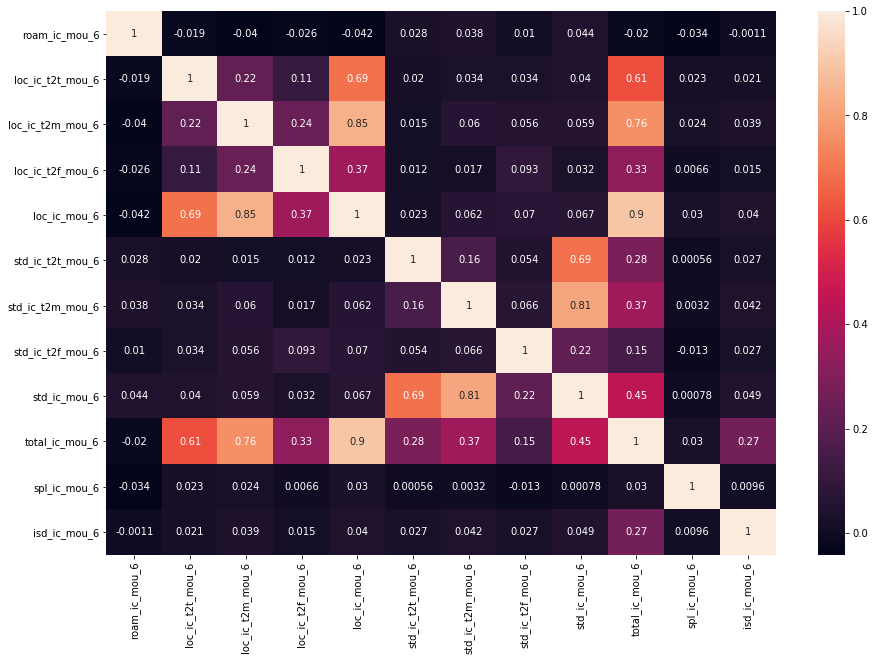

In [39]:
plt.figure(figsize=[15,10])
sns.heatmap(highvalue_customers[june_ic].corr(), annot=True)

#### Remove the summary columns

In [40]:
in_cols_del = ['loc_ic_mou_6','total_ic_mou_6','std_ic_mou_6']

In [41]:
highvalue_customers.drop(in_cols_del, axis=1, inplace=True)
highvalue_customers.shape

(30001, 156)

#### Do the same exercise for outgoing calls

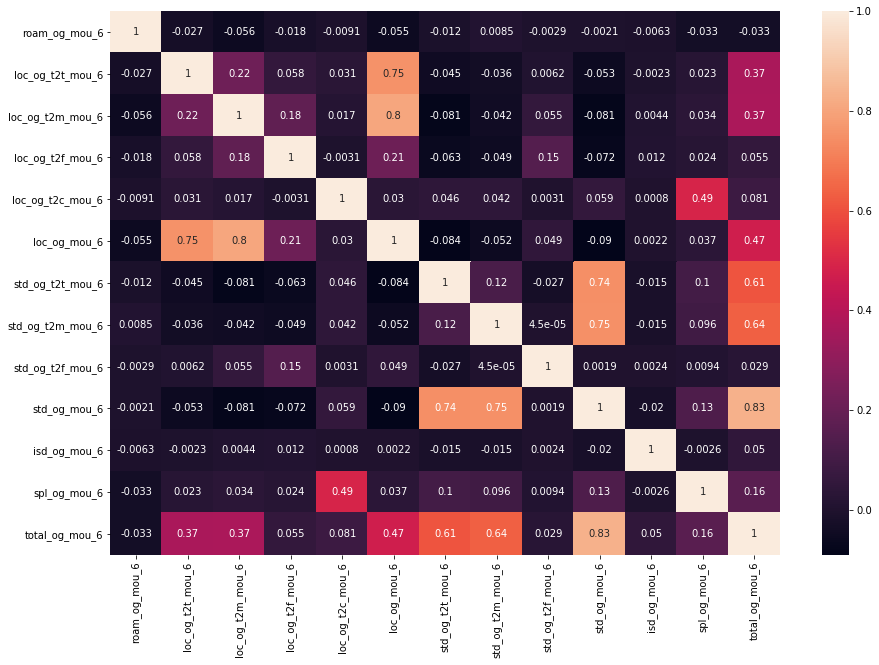

In [42]:
plt.figure(figsize=[15,10])
sns.heatmap(highvalue_customers[june_og].corr(),annot=True)

In [43]:
og_cols_del = ['loc_og_mou_6','std_og_mou_6','total_og_mou_6']

In [44]:
highvalue_customers.drop(og_cols_del, axis=1, inplace=True)

In [45]:
highvalue_customers.shape

(30001, 153)

#### Repeat the same exercise for july(7)

In [46]:
july = [x for x in highvalue_customers.columns if '_7' in x]

In [47]:
july_add = [x for x in highvalue_customers.columns if 'jul_' in x]

In [48]:
for i in july_add:
    july.append(i)

In [49]:
july

['arpu_7',
 'onnet_mou_7',
 'offnet_mou_7',
 'roam_ic_mou_7',
 'roam_og_mou_7',
 'loc_og_t2t_mou_7',
 'loc_og_t2m_mou_7',
 'loc_og_t2f_mou_7',
 'loc_og_t2c_mou_7',
 'loc_og_mou_7',
 'std_og_t2t_mou_7',
 'std_og_t2m_mou_7',
 'std_og_t2f_mou_7',
 'std_og_mou_7',
 'isd_og_mou_7',
 'spl_og_mou_7',
 'og_others_7',
 'total_og_mou_7',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2m_mou_7',
 'loc_ic_t2f_mou_7',
 'loc_ic_mou_7',
 'std_ic_t2t_mou_7',
 'std_ic_t2m_mou_7',
 'std_ic_t2f_mou_7',
 'std_ic_mou_7',
 'total_ic_mou_7',
 'spl_ic_mou_7',
 'isd_ic_mou_7',
 'ic_others_7',
 'total_rech_num_7',
 'total_rech_amt_7',
 'max_rech_amt_7',
 'date_of_last_rech_7',
 'last_day_rch_amt_7',
 'date_of_last_rech_data_7',
 'total_rech_data_7',
 'max_rech_data_7',
 'count_rech_2g_7',
 'count_rech_3g_7',
 'av_rech_amt_data_7',
 'vol_2g_mb_7',
 'vol_3g_mb_7',
 'arpu_3g_7',
 'arpu_2g_7',
 'night_pck_user_7',
 'monthly_2g_7',
 'sachet_2g_7',
 'monthly_3g_7',
 'sachet_3g_7',
 'fb_user_7',
 'jul_vbc_3g']

In [50]:
july_ic = [x for x in july if '_ic_' in x]
july_og = [x for x in july if '_og_' in x]

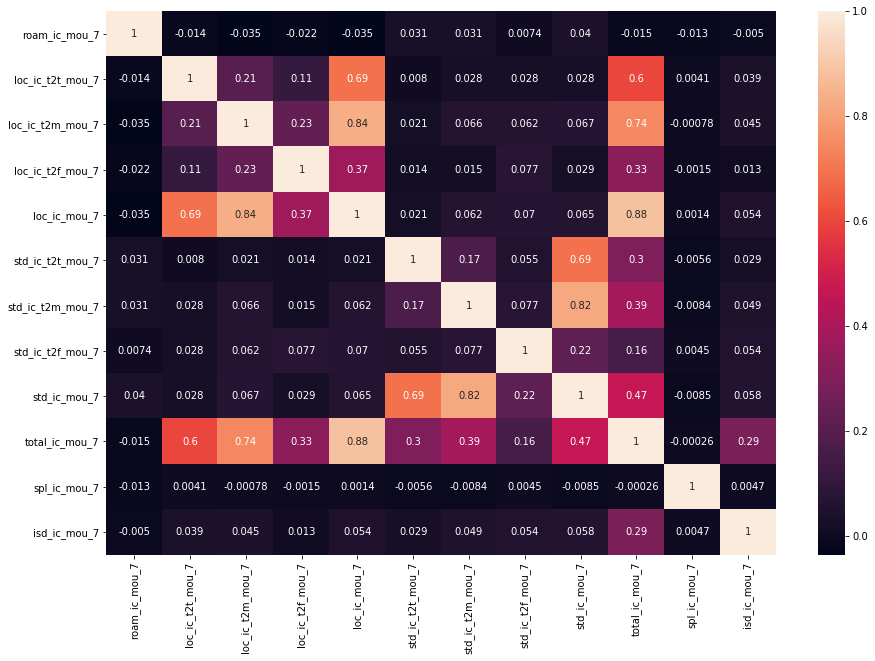

In [51]:
plt.figure(figsize=[15,10])
sns.heatmap(highvalue_customers[july_ic].corr(), annot=True)

#### Remove summary columns

In [52]:
in_cols_del = ['loc_ic_mou_7','std_ic_mou_7','total_ic_mou_7']
highvalue_customers.drop(in_cols_del, axis=1, inplace=True)

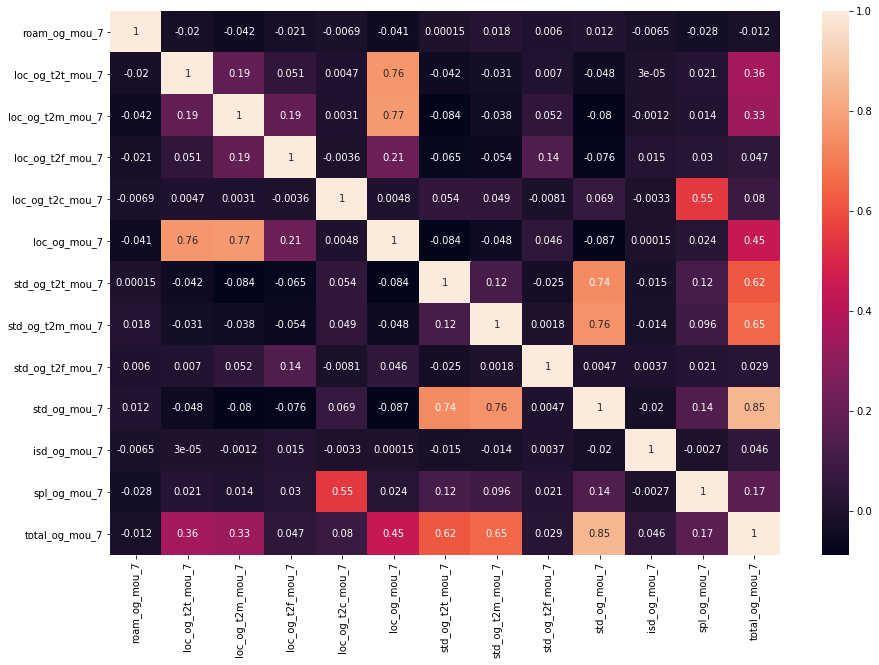

In [53]:
#### Do the same exercise for outgoing calls
plt.figure(figsize=[15,10])
sns.heatmap(highvalue_customers[july_og].corr(),annot=True)

In [54]:
og_cols_del = ['loc_og_mou_7','std_og_mou_7','total_og_mou_7']
highvalue_customers.drop(og_cols_del, axis=1, inplace=True)

In [55]:
highvalue_customers.shape

(30001, 147)

#### Let's move onto month 8 which is the action month to explore possibilities to derive new columns

In [56]:
aug = [x for x in highvalue_customers.columns if '_8' in x]
aug_add = [x for x in highvalue_customers.columns if 'aug_' in x]
for i in aug_add:
    aug.append(i)

In [57]:
aug

['arpu_8',
 'onnet_mou_8',
 'offnet_mou_8',
 'roam_ic_mou_8',
 'roam_og_mou_8',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_8',
 'loc_og_mou_8',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_8',
 'std_og_mou_8',
 'isd_og_mou_8',
 'spl_og_mou_8',
 'og_others_8',
 'total_og_mou_8',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2m_mou_8',
 'loc_ic_t2f_mou_8',
 'loc_ic_mou_8',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_8',
 'std_ic_mou_8',
 'total_ic_mou_8',
 'spl_ic_mou_8',
 'isd_ic_mou_8',
 'ic_others_8',
 'total_rech_num_8',
 'total_rech_amt_8',
 'max_rech_amt_8',
 'date_of_last_rech_8',
 'last_day_rch_amt_8',
 'date_of_last_rech_data_8',
 'total_rech_data_8',
 'max_rech_data_8',
 'count_rech_2g_8',
 'count_rech_3g_8',
 'av_rech_amt_data_8',
 'vol_2g_mb_8',
 'vol_3g_mb_8',
 'arpu_3g_8',
 'arpu_2g_8',
 'night_pck_user_8',
 'monthly_2g_8',
 'sachet_2g_8',
 'monthly_3g_8',
 'sachet_3g_8',
 'fb_user_8',
 'aug_vbc_3g']

In [58]:
aug_ic = [x for x in aug if '_ic_' in x]
aug_og = [x for x in aug if '_og_' in x]

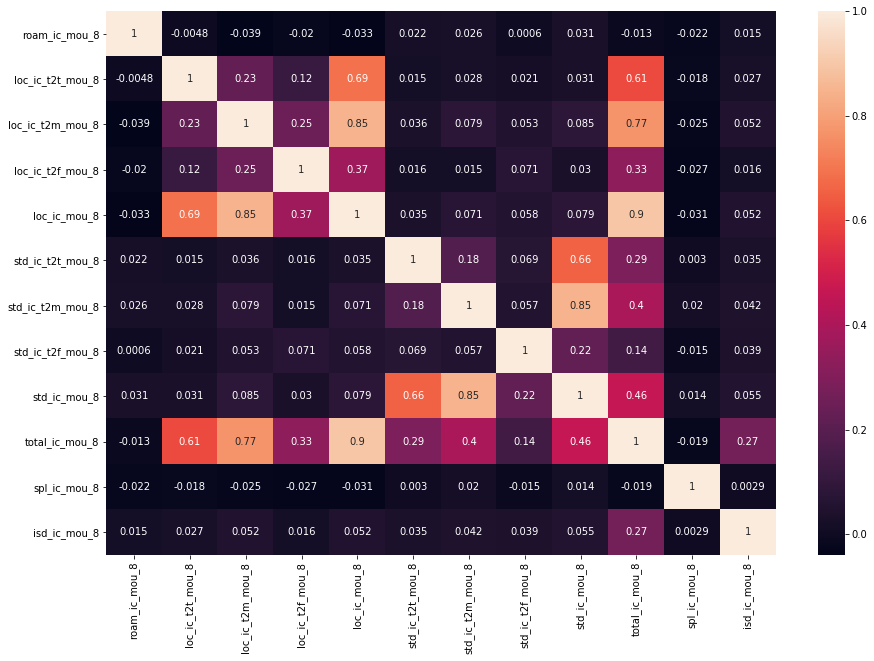

In [59]:
plt.figure(figsize=[15,10])
sns.heatmap(highvalue_customers[aug_ic].corr(), annot=True)

In [60]:
in_cols_del = ['loc_ic_mou_8','total_ic_mou_8','std_ic_mou_8']
highvalue_customers.drop(in_cols_del, axis=1, inplace=True)

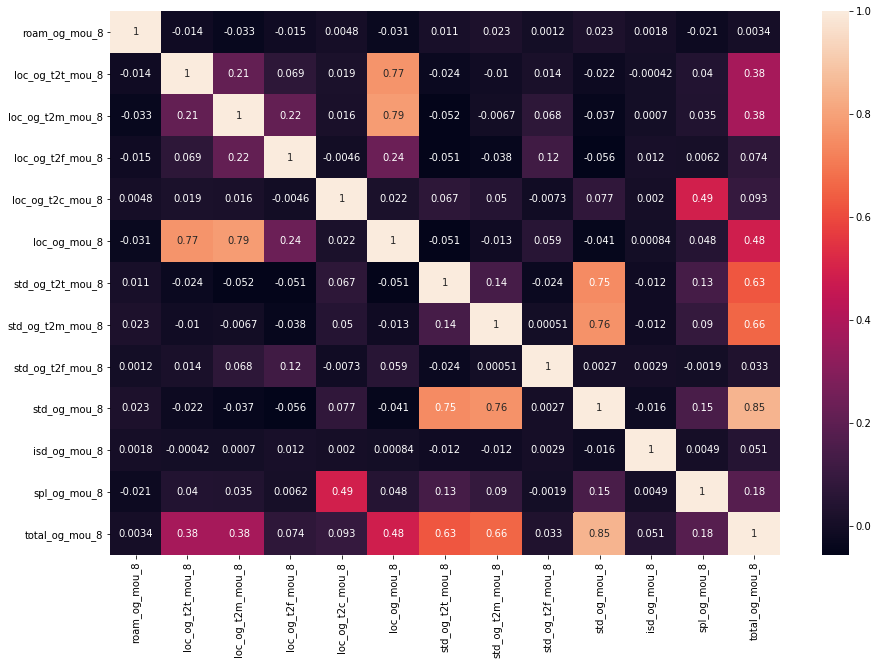

In [61]:
#### Do the same exercise for outgoing calls
plt.figure(figsize=[15,10])
sns.heatmap(highvalue_customers[aug_og].corr(),annot=True)

In [62]:
in_cols_del = ['loc_og_mou_8','total_og_mou_8','std_og_mou_8']
highvalue_customers.drop(in_cols_del, axis=1, inplace=True)

In [63]:
highvalue_customers.shape

(30001, 141)

### Revenue and Amount columns

In [64]:
revenue_df=highvalue_customers[['arpu_6','arpu_7','arpu_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']].corr()

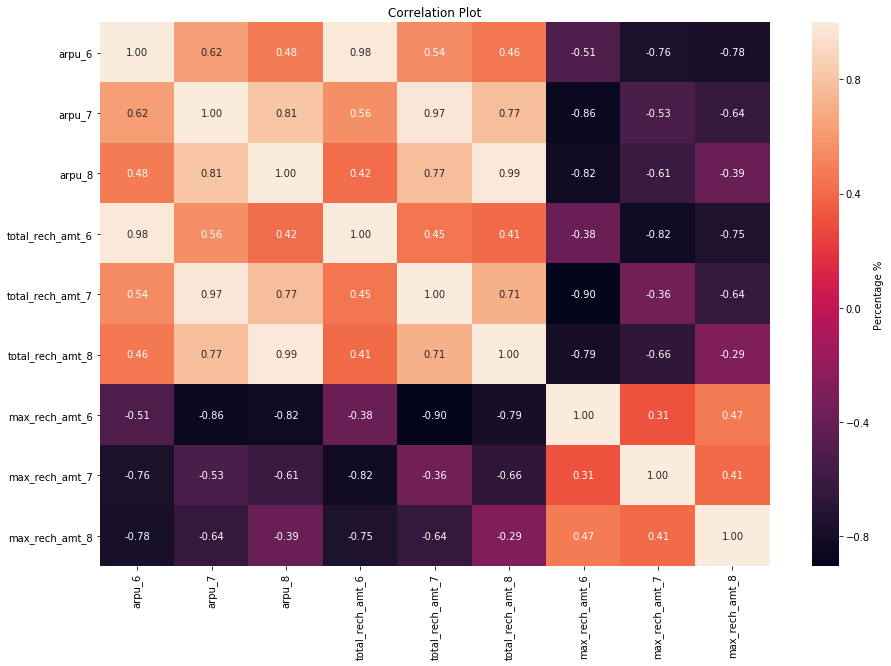

In [65]:
f, ax = plt.subplots(figsize=[15,10])
sns.heatmap(revenue_df.corr(),annot=True, fmt=".2f",cbar_kws={'label': 'Percentage %'},ax=ax)
ax.set_title("Correlation Plot")
plt.show()

#### We can notice there are high correlation between arpu and total_rech_amt
#### We will remove one of them.

In [66]:
highvalue_customers.drop(['arpu_6','arpu_7','arpu_8'],axis=1,inplace=True)

In [67]:
highvalue_customers.shape

(30001, 138)

In [68]:
recharge = ['mobile_number','total_rech_num_6','total_rech_num_7','total_rech_num_8',
             'max_rech_amt_6','max_rech_amt_7','max_rech_amt_8',
             'last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8',
             'total_rech_data_6','total_rech_data_7','total_rech_data_8',
             'max_rech_data_6','max_rech_data_7','max_rech_data_8',
             'count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
             'count_rech_3g_6','count_rech_3g_7','count_rech_3g_8',
             'av_rech_amt_data_6','av_rech_amt_data_7','av_rech_amt_data_8',
             'vol_2g_mb_6','vol_2g_mb_7','vol_2g_mb_8',
             'vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
             'arpu_2g_6','arpu_2g_7','arpu_2g_8',
             'arpu_3g_6','arpu_3g_7','arpu_3g_8',
             'night_pck_user_6','night_pck_user_7','night_pck_user_8',
             'monthly_2g_6','monthly_2g_7','monthly_2g_8',
             'sachet_2g_6','sachet_2g_7','sachet_2g_8',
             'monthly_3g_6','monthly_3g_7','monthly_3g_8',
             'sachet_3g_6','sachet_3g_7','sachet_3g_8',
             'fb_user_6','fb_user_7','fb_user_8',
             'jun_vbc_3g','jul_vbc_3g','aug_vbc_3g',
             'churn']

In [69]:
recharge_df=highvalue_customers[recharge]

In [70]:
jun = [x for x in recharge_df.columns if '_6' in x]
jun_add = [x for x in recharge_df.columns if 'jun_' in x]
for i in jun_add:
    jun.append(i)

In [71]:
jul = [x for x in recharge_df.columns if '_7' in x]
jul_add = [x for x in recharge_df.columns if 'jul_' in x]
for i in jul_add:
    jul.append(i)

In [72]:
aug = [x for x in recharge_df.columns if '_8' in x]
aug_add = [x for x in recharge_df.columns if 'aug_' in x]
for i in aug_add:
    aug.append(i)

#### Recharge Correlation map for June

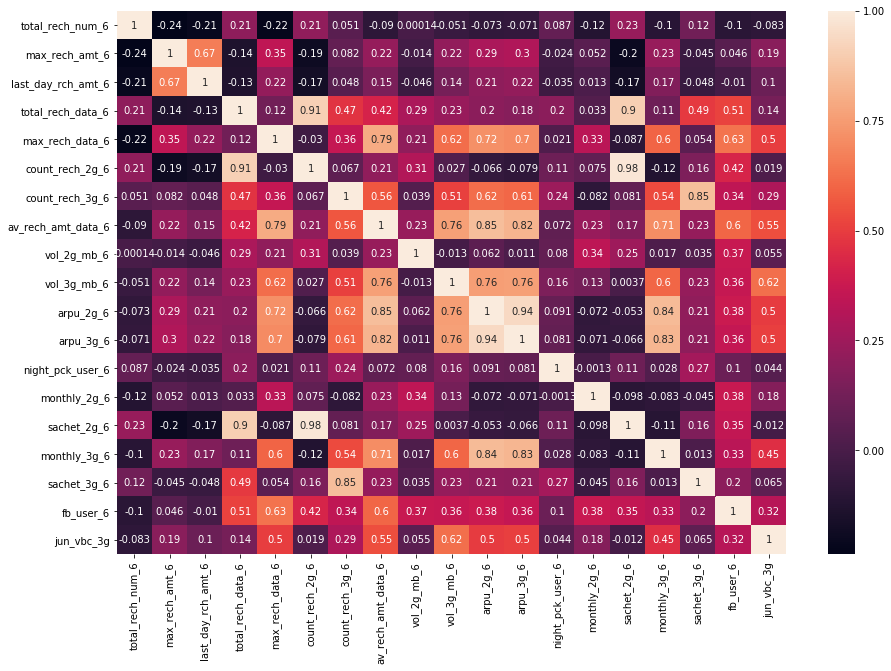

In [73]:

plt.figure(figsize=[15,10])
sns.heatmap(recharge_df[jun].corr(),annot=True)

#### Recharge Correlation map for July

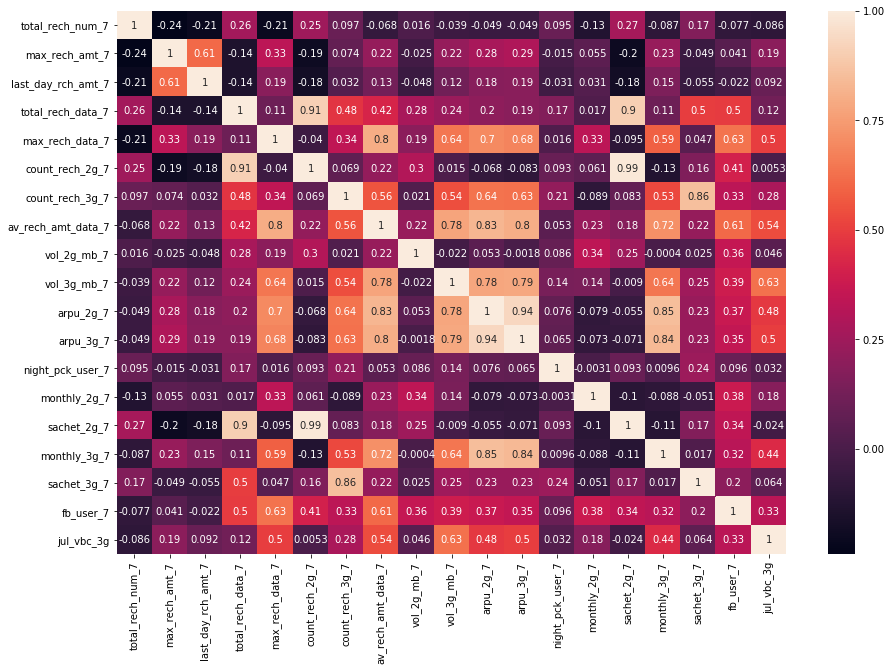

In [74]:
plt.figure(figsize=[15,10])
sns.heatmap(recharge_df[jul].corr(),annot=True)

#### Recharge Correlation map for Aug

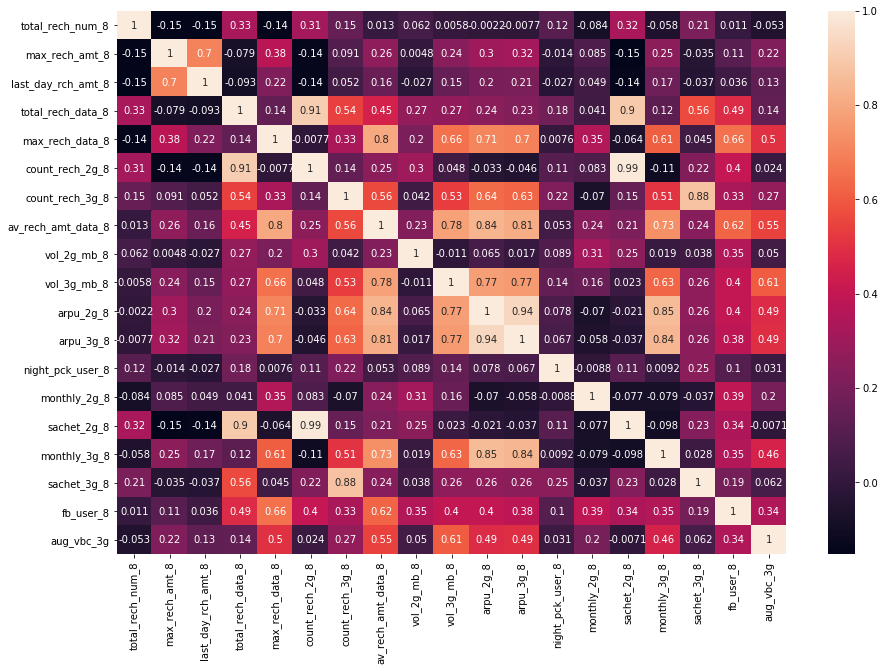

In [75]:
plt.figure(figsize=[15,10])
sns.heatmap(recharge_df[aug].corr(),annot=True)

#### Removing columns with more than .80 correlation

In [76]:
def correlation(dataset, threshold):
    col_corr = set() 
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    print(col_corr)

In [77]:
correlation(recharge_df[jun],.85)
correlation(recharge_df[jul],.85)
correlation(recharge_df[aug],.85)

{'sachet_3g_6', 'arpu_2g_6', 'count_rech_2g_6', 'sachet_2g_6', 'arpu_3g_6'}
{'arpu_3g_7', 'count_rech_2g_7', 'sachet_3g_7', 'sachet_2g_7', 'monthly_3g_7'}
{'sachet_2g_8', 'sachet_3g_8', 'arpu_3g_8', 'monthly_3g_8', 'count_rech_2g_8'}


In [78]:
highvalue_customers.drop(['count_rech_2g_6','count_rech_2g_7','count_rech_2g_8',
'arpu_3g_6','arpu_3g_7','arpu_3g_8',
'sachet_2g_6','sachet_2g_7','sachet_2g_8'],axis=1,inplace=True)

In [79]:
highvalue_customers.shape

(30001, 129)

## Feature engineering of the date columns

Extract only the day part of the date. Set it to 0 for null values.

In [80]:
highvalue_customers['day_of_last_rech_6'] = highvalue_customers.apply(lambda x: pd.to_datetime(x['date_of_last_rech_6']).day if x['date_of_last_rech_6'] is not None else 0, axis=1)
highvalue_customers['day_of_last_rech_7'] = highvalue_customers.apply(lambda x: pd.to_datetime(x['date_of_last_rech_7']).day if x['date_of_last_rech_7'] is not None else 0, axis=1)
highvalue_customers['day_of_last_rech_8'] = highvalue_customers.apply(lambda x: pd.to_datetime(x['date_of_last_rech_8']).day if x['date_of_last_rech_8'] is not None else 0, axis=1)

highvalue_customers['day_of_last_rech_data_6'] = highvalue_customers.apply(lambda x: pd.to_datetime(x['date_of_last_rech_data_6']).day if x['date_of_last_rech_6'] is not None else 0, axis=1)
highvalue_customers['day_of_last_rech_data_7'] = highvalue_customers.apply(lambda x: pd.to_datetime(x['date_of_last_rech_data_7']).day if x['date_of_last_rech_7'] is not None else 0, axis=1)
highvalue_customers['day_of_last_rech_data_8'] = highvalue_customers.apply(lambda x: pd.to_datetime(x['date_of_last_rech_data_8']).day if x['date_of_last_rech_8'] is not None else 0, axis=1)

In [81]:
highvalue_customers[['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']]=highvalue_customers[['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8']].fillna(0)
highvalue_customers[['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8']]=highvalue_customers[['day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8']].fillna(0)

In [82]:
highvalue_customers[['day_of_last_rech_6','day_of_last_rech_7','day_of_last_rech_8','day_of_last_rech_data_6','day_of_last_rech_data_7','day_of_last_rech_data_8']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 6 columns):
day_of_last_rech_6         30001 non-null float64
day_of_last_rech_7         30001 non-null float64
day_of_last_rech_8         30001 non-null float64
day_of_last_rech_data_6    30001 non-null float64
day_of_last_rech_data_7    30001 non-null float64
day_of_last_rech_data_8    30001 non-null float64
dtypes: float64(6)
memory usage: 1.6 MB


In [83]:
#The date columns are now no more needed
highvalue_customers = highvalue_customers.drop(date_columns.columns, axis=1)
highvalue_customers.shape

(30001, 129)

#### Check behaviour in the good phase and find difference with the action phase

In [84]:
cols_mean_diff = ['day_of_last_rech_diff','day_of_last_rech_data_diff']
cols_6 = ['day_of_last_rech_6','day_of_last_rech_data_6']
cols_7 = ['day_of_last_rech_7','day_of_last_rech_data_7']
cols_8 = ['day_of_last_rech_8','day_of_last_rech_data_8']

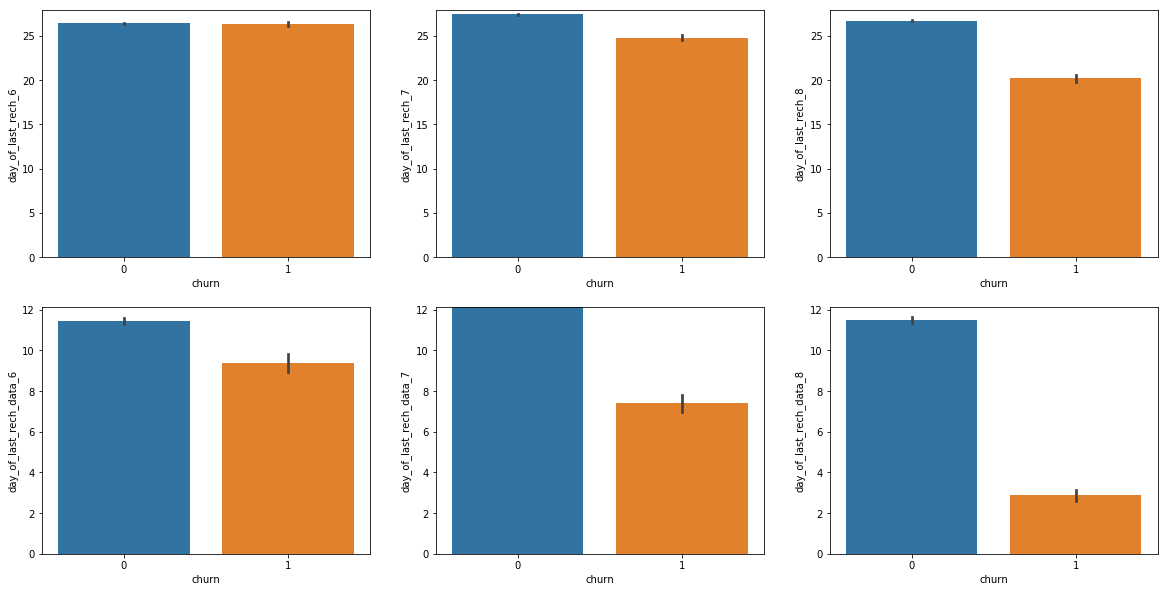

In [85]:
plt.figure(figsize=[20,10])
i=0
for a,b,c in zip(cols_6,cols_7, cols_8):
    i = i+1
    plt.subplot(2,3,i)
    ax1=sns.barplot(x='churn', y=a, data=highvalue_customers)
   
    i = i+1
    ax2=plt.subplot(2,3,i)
    ax2.set_ylim(ax1.get_ylim())
    sns.barplot(x='churn', y=b, data=highvalue_customers)
    
    i = i+1
    ax3=plt.subplot(2,3,i)
    ax3.set_ylim(ax1.get_ylim())
    sns.barplot(x='churn', y=c, data=highvalue_customers)

In [86]:
for a,b,c,d in zip(cols_mean_diff, cols_6,cols_7, cols_8):
    highvalue_customers[a] = ((highvalue_customers[b] + highvalue_customers[c])/2) - highvalue_customers[d]

In [87]:
highvalue_customers.drop(cols_6,axis=1,inplace=True)
highvalue_customers.drop(cols_7,axis=1,inplace=True)
highvalue_customers.drop(cols_8,axis=1,inplace=True)

In [88]:
highvalue_customers.columns.values

array(['mobile_number', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6',
       'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7',
       'roam_og_mou_8', 'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7',
       'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7',
       'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7',
       'loc_og_t2c_mou_8', 'std_og_t2t_mou_6', 'std_og_t2t_mou_7',
       'std_og_t2t_mou_8', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2m_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7',
       'std_og_t2f_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'l

## Feature engineering MOU columns

#### Since months 6&7 are considered as good months, user behavior is similar in these months. This is evident in the comparison graphs shown below for these fields.
#### So let's take an average of the key incoming and outgoing calls usage attributes across these months

In [89]:
new_cols = ['avg_loc_og_t2t_mou_good','avg_loc_og_t2m_mou_good','avg_loc_og_t2f_mou_good','avg_loc_og_t2c_mou_good','avg_std_og_t2t_mou_good','avg_std_og_t2m_mou_good','avg_std_og_t2f_mou_good','avg_loc_ic_t2t_mou_good','avg_loc_ic_t2m_mou_good','avg_loc_ic_t2f_mou_good','avg_std_ic_t2t_mou_good','avg_std_ic_t2m_mou_good','avg_std_ic_t2f_mou_good']
cols_6 = ['loc_og_t2t_mou_6','loc_og_t2m_mou_6','loc_og_t2f_mou_6','loc_og_t2c_mou_6','std_og_t2t_mou_6','std_og_t2m_mou_6','std_og_t2f_mou_6','loc_ic_t2t_mou_6','loc_ic_t2m_mou_6','loc_ic_t2f_mou_6','std_ic_t2t_mou_6','std_ic_t2m_mou_6','std_ic_t2f_mou_6']
cols_7 = ['loc_og_t2t_mou_7','loc_og_t2m_mou_7','loc_og_t2f_mou_7','loc_og_t2c_mou_7','std_og_t2t_mou_7','std_og_t2m_mou_7','std_og_t2f_mou_7','loc_ic_t2t_mou_7','loc_ic_t2m_mou_7','loc_ic_t2f_mou_7','std_ic_t2t_mou_7','std_ic_t2m_mou_7','std_ic_t2f_mou_7']
cols_8 = ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8']

In [90]:
len(cols_8)

13

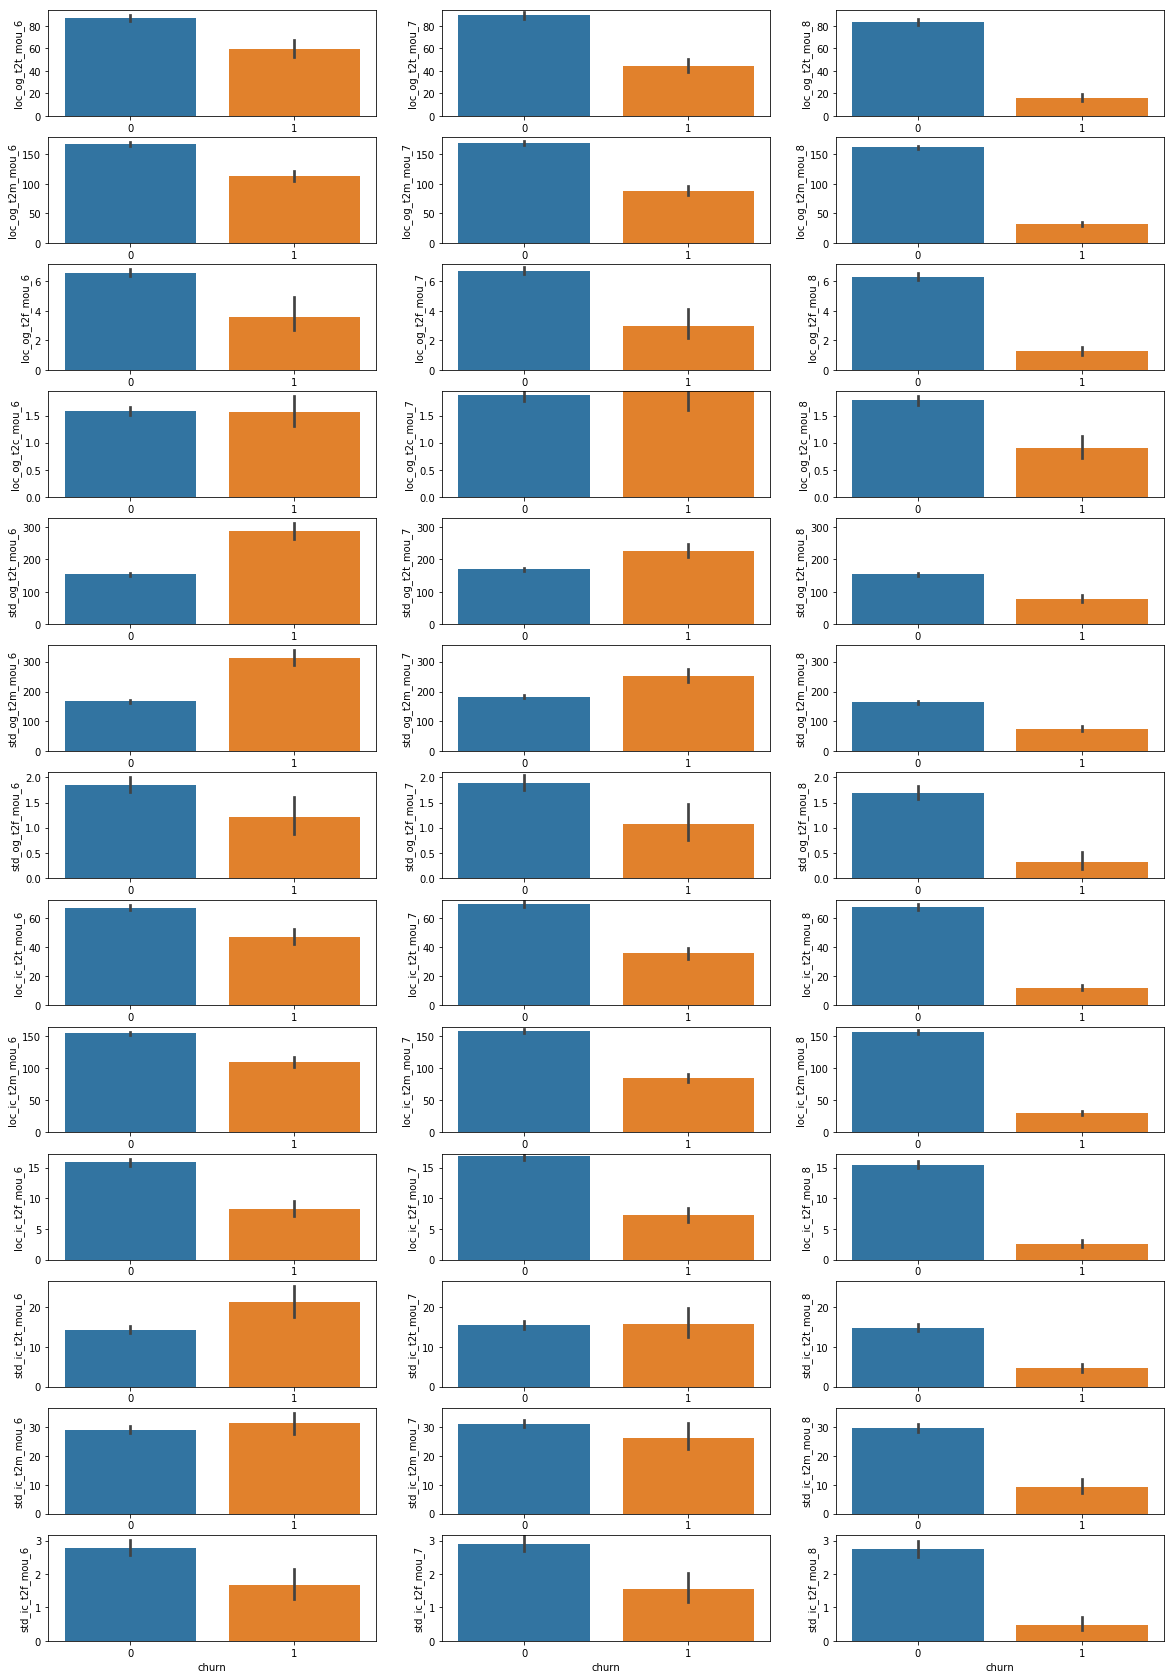

In [91]:
plt.figure(figsize=[20,30])
i=0
for a,b,c in zip(cols_6,cols_7, cols_8):
    i = i+1
    plt.subplot(13,3,i)
    ax1=sns.barplot(x='churn', y=a, data=highvalue_customers)
   
    i = i+1
    ax2=plt.subplot(13,3,i)
    ax2.set_ylim(ax1.get_ylim())
    sns.barplot(x='churn', y=b, data=highvalue_customers)
    
    i = i+1
    ax3=plt.subplot(13,3,i)
    ax3.set_ylim(ax1.get_ylim())
    sns.barplot(x='churn', y=c, data=highvalue_customers)

In [92]:
for x,y,z in zip(new_cols,cols_6,cols_7):
    highvalue_customers[x] = (highvalue_customers[y]+highvalue_customers[z])/2

In [93]:
highvalue_customers[new_cols].describe()

,avg_loc_og_t2t_mou_good,avg_loc_og_t2m_mou_good,avg_loc_og_t2f_mou_good,avg_loc_og_t2c_mou_good,avg_std_og_t2t_mou_good,avg_std_og_t2m_mou_good,avg_std_og_t2f_mou_good,avg_loc_ic_t2t_mou_good,avg_loc_ic_t2m_mou_good,avg_loc_ic_t2f_mou_good,avg_std_ic_t2t_mou_good,avg_std_ic_t2m_mou_good,avg_std_ic_t2f_mou_good
count,30001.000000,30001.000000,30001.000000,30001.00000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,85.079520,163.126630,6.383899,1.73249,170.059634,183.677078,1.814799,66.045108,151.018801,15.657016,15.158141,30.008866,2.747149
std,222.279441,232.215248,20.955732,6.48236,385.607865,393.887902,11.529439,157.153746,207.004076,44.348676,75.054257,93.957854,17.908139
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.460000,24.695000,0.000000,0.00000,0.000000,0.500000,0.000000,8.535000,34.090000,0.180000,0.000000,0.700000,0.000000
50%,26.690000,82.430000,0.640000,0.00000,5.430000,22.230000,0.000000,27.345000,87.675000,2.620000,1.405000,6.995000,0.000000
75%,79.360000,211.345000,4.720000,1.13000,132.125000,173.510000,0.000000,68.585000,189.735000,12.900000,9.880000,26.010000,0.680000
max,5941.565000,4150.165000,1331.230000,420.57500,7308.050000,7857.410000,382.920000,5716.160000,4432.685000,1358.435000,5630.245000,3122.585000,1185.045000


In [94]:
highvalue_customers[cols_6].describe()

,loc_og_t2t_mou_6,loc_og_t2m_mou_6,loc_og_t2f_mou_6,loc_og_t2c_mou_6,std_og_t2t_mou_6,std_og_t2m_mou_6,std_og_t2f_mou_6,loc_ic_t2t_mou_6,loc_ic_t2m_mou_6,loc_ic_t2f_mou_6,std_ic_t2t_mou_6,std_ic_t2m_mou_6,std_ic_t2f_mou_6
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,84.484753,163.243297,6.344115,1.575104,165.885296,179.433389,1.803548,65.453285,150.412393,15.278467,14.894779,29.195215,2.695855
std,228.794004,250.116700,22.123561,6.303385,403.831965,409.025814,11.979429,163.738880,219.198969,45.751937,77.695681,98.210477,19.099927
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.380000,19.210000,0.000000,0.000000,0.000000,0.000000,0.000000,6.090000,28.080000,0.000000,0.000000,0.000000,0.000000
50%,24.330000,77.180000,0.000000,0.000000,2.710000,16.360000,0.000000,25.080000,84.060000,1.840000,0.380000,5.000000,0.000000
75%,77.980000,208.930000,4.230000,0.000000,109.610000,154.540000,0.000000,67.430000,188.710000,11.980000,8.200000,23.600000,0.110000
max,6431.330000,4729.740000,1466.030000,271.440000,7366.580000,8314.760000,628.560000,6351.440000,4693.860000,1678.410000,5459.560000,4630.230000,1351.110000


In [95]:
highvalue_customers[cols_7].describe()

,loc_og_t2t_mou_7,loc_og_t2m_mou_7,loc_og_t2f_mou_7,loc_og_t2c_mou_7,std_og_t2t_mou_7,std_og_t2m_mou_7,std_og_t2f_mou_7,loc_ic_t2t_mou_7,loc_ic_t2m_mou_7,loc_ic_t2f_mou_7,std_ic_t2t_mou_7,std_ic_t2m_mou_7,std_ic_t2f_mou_7
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.00000,30001.000000,30001.000000,30001.000000,30001.000000
mean,85.674287,163.009963,6.423683,1.889875,174.233972,187.920768,1.826051,66.636931,151.62521,16.035566,15.421504,30.822517,2.798443
std,240.525999,241.576705,21.944183,9.158984,421.190177,433.632143,12.980269,167.403827,218.24326,49.165972,83.042730,105.664499,19.514504
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,4.610000,20.460000,0.000000,0.000000,0.000000,0.000000,0.000000,6.780000,30.78000,0.000000,0.000000,0.000000,0.000000
50%,24.680000,78.880000,0.100000,0.000000,2.680000,16.040000,0.000000,25.780000,85.66000,2.000000,0.450000,5.180000,0.000000
75%,78.340000,208.410000,4.380000,0.100000,116.610000,160.280000,0.000000,68.640000,190.66000,12.240000,8.590000,24.940000,0.200000
max,7400.660000,4557.140000,1196.430000,569.710000,8133.660000,9284.740000,544.630000,5709.590000,4171.51000,1983.010000,5800.930000,3470.380000,1136.080000


#### As we know month 8 is the action month which implies changes in customer behavior compared to previous 2 months. The difference in minutes used between month 8 and month 6,7 average should capture the difference in customer behavior.
1. Calculate the difference in minutes used between august and june, july.
2. Verify if the newly created difference column has an impact on churn.

In [96]:
cols_diff = ['loc_og_t2t_mou_diff','loc_og_t2m_mou_diff','loc_og_t2f_mou_diff','loc_og_t2c_mou_diff','std_og_t2t_mou_diff','std_og_t2m_mou_diff','std_og_t2f_mou_diff','loc_ic_t2t_mou_diff','loc_ic_t2m_mou_diff','loc_ic_t2f_mou_diff','std_ic_t2t_mou_diff','std_ic_t2m_mou_diff','std_ic_t2f_mou_diff']
cols_good = ['avg_loc_og_t2t_mou_good','avg_loc_og_t2m_mou_good','avg_loc_og_t2f_mou_good','avg_loc_og_t2c_mou_good','avg_std_og_t2t_mou_good','avg_std_og_t2m_mou_good','avg_std_og_t2f_mou_good','avg_loc_ic_t2t_mou_good','avg_loc_ic_t2m_mou_good','avg_loc_ic_t2f_mou_good','avg_std_ic_t2t_mou_good','avg_std_ic_t2m_mou_good','avg_std_ic_t2f_mou_good']
cols_8 = ['loc_og_t2t_mou_8','loc_og_t2m_mou_8','loc_og_t2f_mou_8','loc_og_t2c_mou_8','std_og_t2t_mou_8','std_og_t2m_mou_8','std_og_t2f_mou_8','loc_ic_t2t_mou_8','loc_ic_t2m_mou_8','loc_ic_t2f_mou_8','std_ic_t2t_mou_8','std_ic_t2m_mou_8','std_ic_t2f_mou_8']

for x,y,z in zip(cols_diff, cols_good, cols_8):
    highvalue_customers[x] = highvalue_customers[y] - highvalue_customers[z]

#### Statistics of the derived columns appear consistent with the old ones so let's delete the old columns

In [97]:
highvalue_customers.drop(cols_6,axis=1,inplace=True)
highvalue_customers.drop(cols_7,axis=1,inplace=True)
highvalue_customers.drop(cols_8,axis=1,inplace=True)
highvalue_customers.drop(cols_good,axis=1,inplace=True)

In [98]:
highvalue_customers.shape

(30001, 99)

#### Do a similar exercise on the remaining MOU columns and check if the pattern is the same in the graphs.

In [99]:
cols_mean_diff = ['onnet_mou_diff','offnet_mou_diff','roam_og_mou_diff','roam_ic_mou_diff','isd_og_mou_diff','isd_ic_mou_diff','spl_og_mou_diff','spl_ic_mou_diff','og_others_diff','ic_others_diff']
cols_6 = ['onnet_mou_6','offnet_mou_6','roam_og_mou_6','roam_ic_mou_6','isd_og_mou_6','isd_ic_mou_6','spl_og_mou_6','spl_ic_mou_6','og_others_6','ic_others_6']
cols_7 = ['onnet_mou_7','offnet_mou_7','roam_og_mou_7','roam_ic_mou_7','isd_og_mou_7','isd_ic_mou_7','spl_og_mou_7','spl_ic_mou_7','og_others_7','ic_others_7']
cols_8 = ['onnet_mou_8','offnet_mou_8','roam_og_mou_8','roam_ic_mou_8','isd_og_mou_8','isd_ic_mou_8','spl_og_mou_8','spl_ic_mou_8','og_others_8','ic_others_8']

In [100]:
len(cols_6)

10

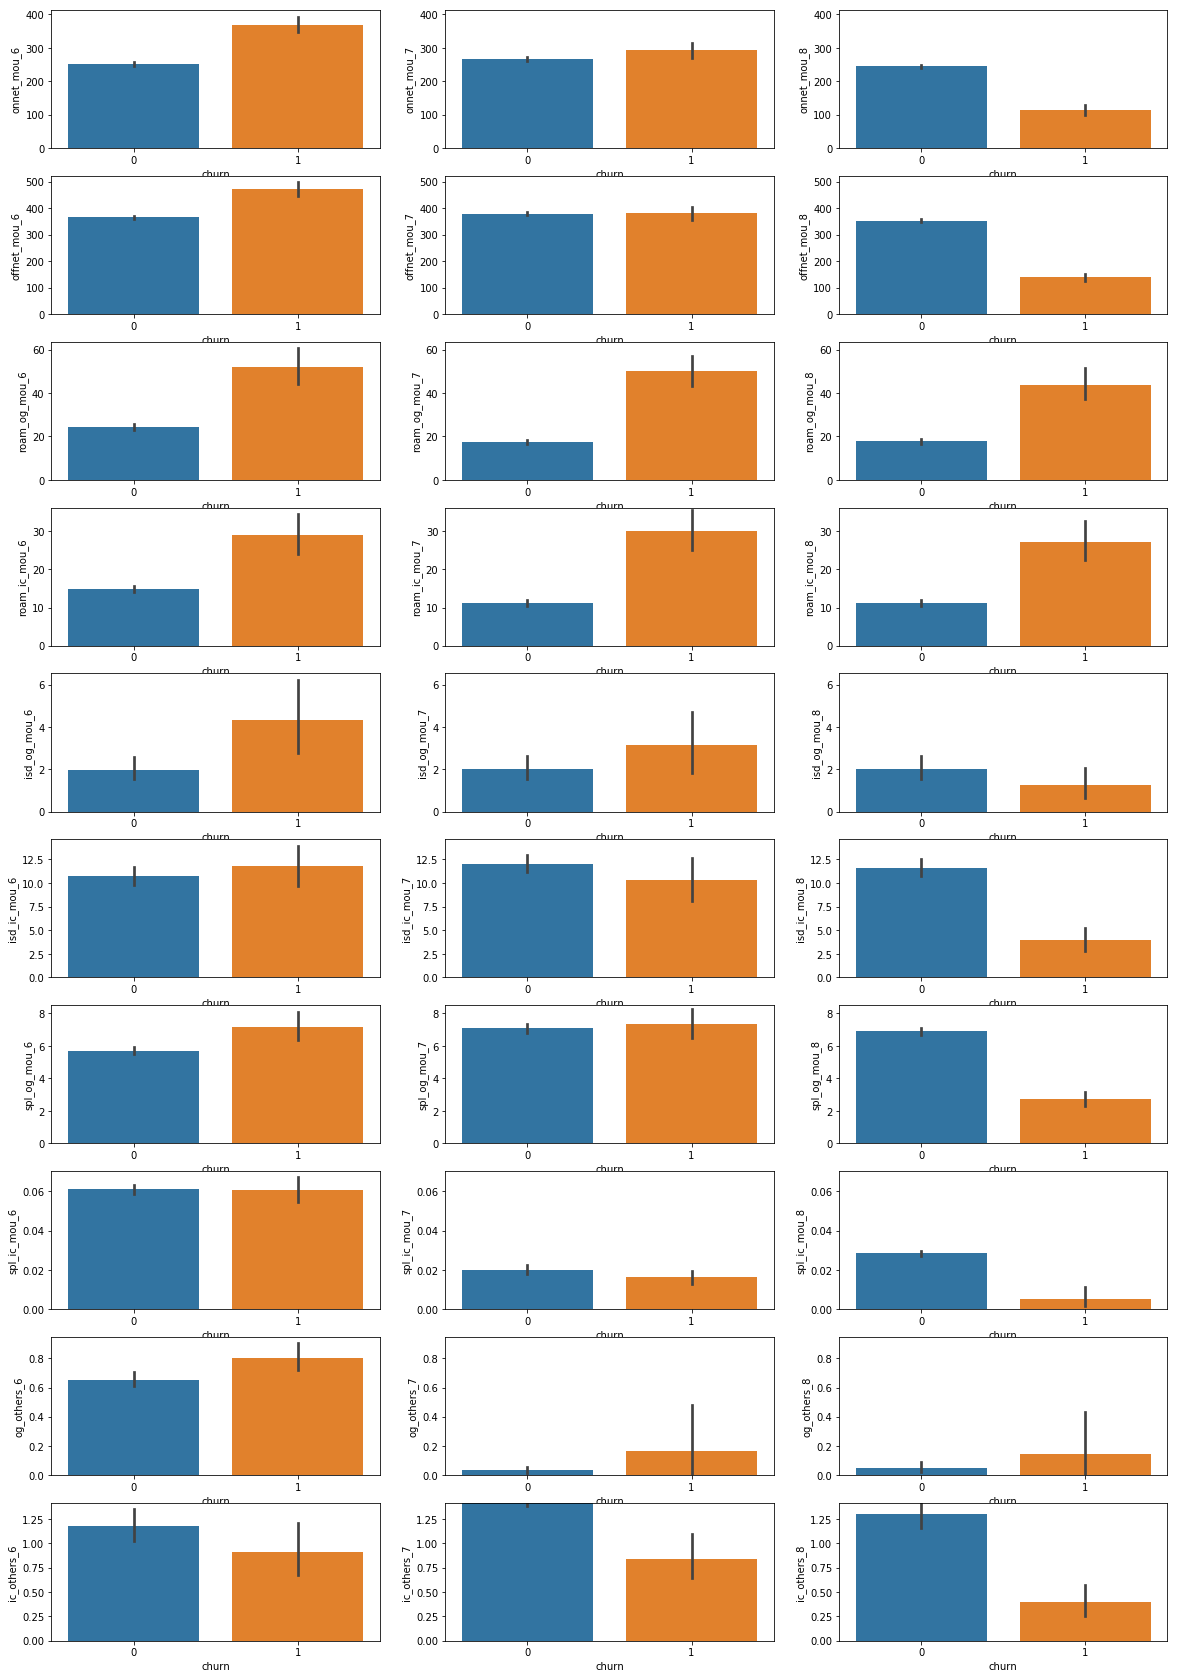

In [101]:
plt.figure(figsize=[20,30])
i=0
for a,b,c in zip(cols_6,cols_7, cols_8):
    i = i+1
    plt.subplot(10,3,i)
    ax1=sns.barplot(x='churn', y=a, data=highvalue_customers)
   
    i = i+1
    ax2=plt.subplot(10,3,i)
    ax2.set_ylim(ax1.get_ylim())
    sns.barplot(x='churn', y=b, data=highvalue_customers)
    
    i = i+1
    ax3=plt.subplot(10,3,i)
    ax3.set_ylim(ax1.get_ylim())
    sns.barplot(x='churn', y=c, data=highvalue_customers)

#### The roaming columns do not show any changes in behaviour for the churned customers specifically. So will be dropping the roaming columns. Other are following the same behaviour and so the difference will be calculated between the good and the action months.
#### Also the behaviour of og_others and spl_ic_mou is not the same for months 6 and 7. Hence will not be taking average of these fileds.

In [102]:
highvalue_customers[cols_6].describe()

,onnet_mou_6,offnet_mou_6,roam_og_mou_6,roam_ic_mou_6,isd_og_mou_6,isd_ic_mou_6,spl_og_mou_6,spl_ic_mou_6,og_others_6,ic_others_6
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,260.793024,373.693961,26.571547,16.110355,2.171525,10.784689,5.818270,0.061035,0.661092,1.153449
std,459.644368,482.523558,116.205525,76.302156,45.852190,76.729297,17.567237,0.188058,4.107960,13.985934
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.080000,71.610000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,84.580000,222.540000,0.000000,0.000000,0.000000,0.000000,0.210000,0.000000,0.000000,0.000000
75%,290.440000,487.940000,0.000000,0.000000,0.000000,0.000000,5.210000,0.000000,0.000000,0.050000
max,7376.710000,8362.360000,3775.110000,2613.310000,5900.660000,6789.410000,1023.210000,19.760000,609.810000,1344.140000


In [103]:
highvalue_customers[cols_7].describe()

,onnet_mou_7,offnet_mou_7,roam_og_mou_7,roam_ic_mou_7,isd_og_mou_7,isd_ic_mou_7,spl_og_mou_7,spl_ic_mou_7,og_others_7,ic_others_7
count,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,267.819295,378.103169,20.152086,12.642504,2.105743,11.875796,7.108646,0.019765,0.042905,1.500338
std,479.993989,498.923555,96.100428,75.785903,45.545227,80.179312,21.788304,0.181859,2.676794,15.997307
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.030000,69.910000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,82.810000,220.030000,0.000000,0.000000,0.000000,0.000000,0.710000,0.000000,0.000000,0.000000
75%,290.240000,494.010000,0.000000,0.000000,0.000000,0.000000,6.940000,0.000000,0.000000,0.000000
max,8157.780000,9667.130000,2812.040000,3813.290000,5490.280000,4747.910000,1265.790000,21.330000,370.130000,1495.940000


In [104]:
cols_6.remove('spl_ic_mou_6')
cols_6.remove('og_others_6')
cols_7.remove('spl_ic_mou_7')
cols_7.remove('og_others_7')
cols_8.remove('spl_ic_mou_8')
cols_8.remove('og_others_8')
cols_mean_diff.remove('spl_ic_mou_diff')
cols_mean_diff.remove('og_others_diff')

In [105]:
for a,b,c,d in zip(cols_mean_diff, cols_6,cols_7, cols_8):
    highvalue_customers[a] = ((highvalue_customers[b] + highvalue_customers[c])/2) - highvalue_customers[d]

In [106]:
highvalue_customers.drop(cols_6,axis=1,inplace=True)
highvalue_customers.drop(cols_7,axis=1,inplace=True)
highvalue_customers.drop(cols_8,axis=1,inplace=True)

In [107]:
highvalue_customers.shape

(30001, 83)

In [108]:
highvalue_customers.columns.values

array(['mobile_number', 'og_others_6', 'og_others_7', 'og_others_8',
       'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'total_rech_data_6',
       'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'count_rech_3g_6',
       'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6',
       'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_2g_mb_6',
       'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'arpu_2g_6', 'arpu_2g_7', 'arpu_2g_8',
       'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8',
       'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_6',
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 's

In [109]:
highvalue_customers.shape

(30001, 83)

## Feature engineering of the Recharge columns
#### A similar behaviour is checked for the recharge related columns and a similar calculation is done for them too.

In [110]:
cols_mean_diff = ['sachet_3g_diff','total_rech_amt_diff','total_rech_num_diff','arpu_2g_diff','max_rech_amt_diff','last_day_rch_amt_diff','total_rech_data_diff','max_rech_data_diff','count_rech_3g_diff','av_rech_amt_data_diff','vol_2g_mb_diff','vol_3g_mb_diff','night_pck_user_diff','monthly_2g_diff','monthly_3g_diff','fb_user_diff','vbc_3g_diff']
cols_6 = ['sachet_3g_6','total_rech_amt_6','total_rech_num_6','arpu_2g_6','max_rech_amt_6','last_day_rch_amt_6','total_rech_data_6','max_rech_data_6','count_rech_3g_6','av_rech_amt_data_6','vol_2g_mb_6','vol_3g_mb_6','night_pck_user_6','monthly_2g_6','monthly_3g_6','fb_user_6','jun_vbc_3g']
cols_7 = ['sachet_3g_7','total_rech_amt_7','total_rech_num_7','arpu_2g_7','max_rech_amt_7','last_day_rch_amt_7','total_rech_data_7','max_rech_data_7','count_rech_3g_7','av_rech_amt_data_7','vol_2g_mb_7','vol_3g_mb_7','night_pck_user_7','monthly_2g_7','monthly_3g_7','fb_user_7','jul_vbc_3g']
cols_8 = ['sachet_3g_8','total_rech_amt_8','total_rech_num_8','arpu_2g_8','max_rech_amt_8','last_day_rch_amt_8','total_rech_data_8','max_rech_data_8','count_rech_3g_8','av_rech_amt_data_8','vol_2g_mb_8','vol_3g_mb_8','night_pck_user_8','monthly_2g_8','monthly_3g_8','fb_user_8','aug_vbc_3g']

In [111]:
len(cols_6)

17

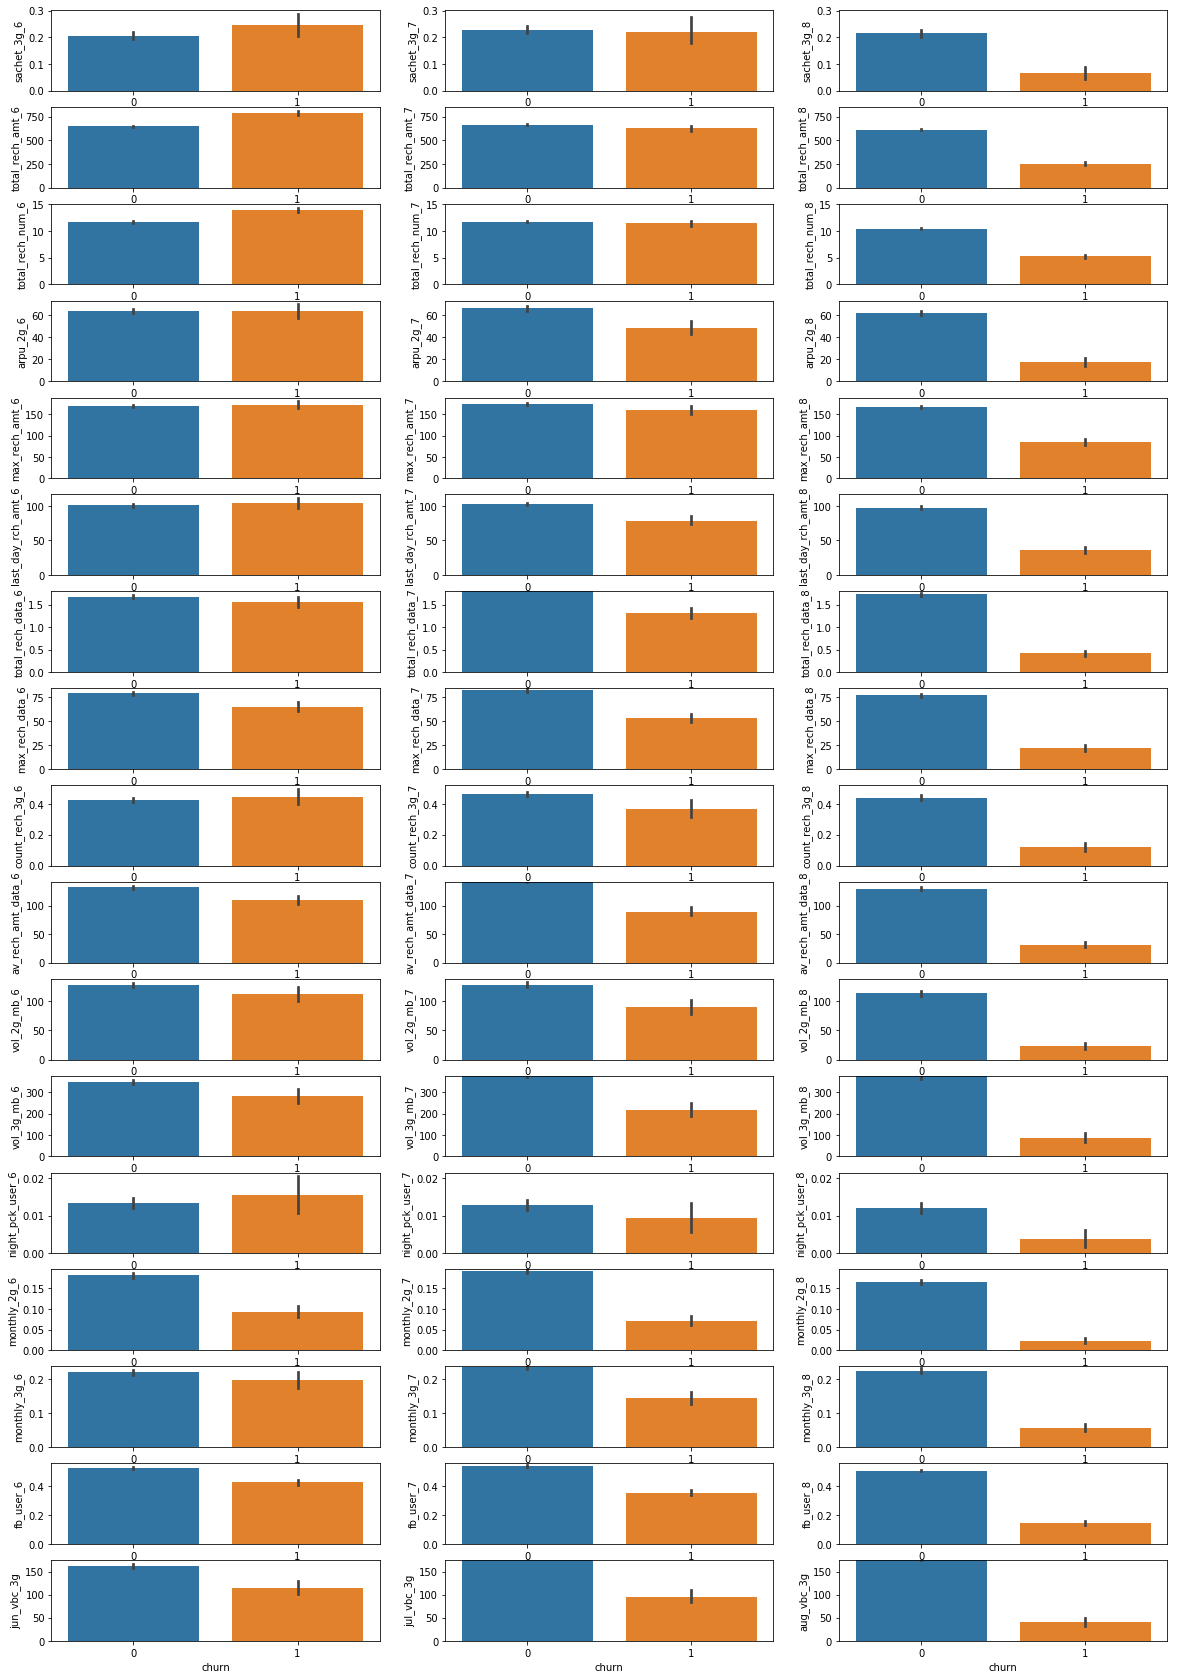

In [112]:
plt.figure(figsize=[20,30])
i=0
for a,b,c in zip(cols_6,cols_7, cols_8):
    i = i+1
    plt.subplot(17,3,i)
    ax1=sns.barplot(x='churn', y=a, data=highvalue_customers)
   
    i = i+1
    ax2=plt.subplot(17,3,i)
    ax2.set_ylim(ax1.get_ylim())
    sns.barplot(x='churn', y=b, data=highvalue_customers)
    
    i = i+1
    ax3=plt.subplot(17,3,i)
    ax3.set_ylim(ax1.get_ylim())
    sns.barplot(x='churn', y=c, data=highvalue_customers)

In [113]:
for a,b,c,d in zip(cols_mean_diff, cols_6,cols_7, cols_8):
    highvalue_customers[a] = ((highvalue_customers[b] + highvalue_customers[c])/2) - highvalue_customers[d]

In [114]:
highvalue_customers.drop(cols_6,axis=1,inplace=True)
highvalue_customers.drop(cols_7,axis=1,inplace=True)
highvalue_customers.drop(cols_8,axis=1,inplace=True)

In [115]:
highvalue_customers.shape

(30001, 49)

In [116]:
highvalue_customers.columns.values

array(['mobile_number', 'og_others_6', 'og_others_7', 'og_others_8',
       'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'aon', 'churn',
       'day_of_last_rech_diff', 'day_of_last_rech_data_diff',
       'loc_og_t2t_mou_diff', 'loc_og_t2m_mou_diff',
       'loc_og_t2f_mou_diff', 'loc_og_t2c_mou_diff',
       'std_og_t2t_mou_diff', 'std_og_t2m_mou_diff',
       'std_og_t2f_mou_diff', 'loc_ic_t2t_mou_diff',
       'loc_ic_t2m_mou_diff', 'loc_ic_t2f_mou_diff',
       'std_ic_t2t_mou_diff', 'std_ic_t2m_mou_diff',
       'std_ic_t2f_mou_diff', 'onnet_mou_diff', 'offnet_mou_diff',
       'roam_og_mou_diff', 'roam_ic_mou_diff', 'isd_og_mou_diff',
       'isd_ic_mou_diff', 'spl_og_mou_diff', 'ic_others_diff',
       'sachet_3g_diff', 'total_rech_amt_diff', 'total_rech_num_diff',
       'arpu_2g_diff', 'max_rech_amt_diff', 'last_day_rch_amt_diff',
       'total_rech_data_diff', 'max_rech_data_diff', 'count_rech_3g_diff',
       'av_rech_amt_data_diff', 'vol_2g_mb_diff', 'vol_3g_mb_diff',
 

In [117]:
highvalue_customers.drop(['roam_og_mou_diff','roam_ic_mou_diff'],axis=1,inplace=True)

In [118]:
highvalue_customers.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,mobile_number,og_others_6,og_others_7,og_others_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,aon,churn,day_of_last_rech_diff,day_of_last_rech_data_diff,loc_og_t2t_mou_diff,loc_og_t2m_mou_diff,loc_og_t2f_mou_diff,loc_og_t2c_mou_diff,std_og_t2t_mou_diff,std_og_t2m_mou_diff,std_og_t2f_mou_diff,loc_ic_t2t_mou_diff,loc_ic_t2m_mou_diff,loc_ic_t2f_mou_diff,std_ic_t2t_mou_diff,std_ic_t2m_mou_diff,std_ic_t2f_mou_diff,onnet_mou_diff,offnet_mou_diff,isd_og_mou_diff,isd_ic_mou_diff,spl_og_mou_diff,ic_others_diff,sachet_3g_diff,total_rech_amt_diff,total_rech_num_diff,arpu_2g_diff,max_rech_amt_diff,last_day_rch_amt_diff,total_rech_data_diff,max_rech_data_diff,count_rech_3g_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff,night_pck_user_diff,monthly_2g_diff,monthly_3g_diff,fb_user_diff,vbc_3g_diff
count,3.000100e+04,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000,30001.000000
mean,7.001206e+09,0.661092,0.042905,0.057607,0.061035,0.019765,0.026567,1209.368754,0.081364,0.620496,0.815089,7.002408,11.369818,0.497514,0.024744,21.618459,26.327010,0.230066,3.425675,4.786070,1.253842,1.244436,2.086269,0.185179,30.193620,40.821520,0.189665,0.331985,-0.093746,0.102438,0.016049,76.249725,1.812056,5.675100,10.598813,8.231159,0.138845,6.467768,0.028416,13.085795,19.896683,5.733637,0.001667,0.025249,0.012366,0.043682,-0.440497
std,6.908784e+05,4.107960,2.676794,3.315125,0.188058,0.181859,0.110697,957.677989,0.273398,6.106545,10.271457,138.240028,148.307664,14.046863,6.974352,273.056056,303.760044,7.536745,102.050822,134.931249,29.499749,58.644175,74.416033,13.707181,308.732579,349.434892,14.001271,56.736330,18.088160,9.582714,0.871149,418.479122,6.755899,116.362092,136.893018,145.251806,2.214561,78.343307,0.992313,148.249896,256.114926,624.877555,0.096681,0.353771,0.474128,0.361410,316.100543
min,7.000000e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,-25.500000,-31.000000,-6412.690000,-3158.700000,-452.720000,-193.355000,-4806.465000,-12685.460000,-209.935000,-3743.340000,-3159.400000,-1039.310000,-3313.875000,-2978.665000,-1023.320000,-6359.920000,-12604.240000,-544.780000,-3163.690000,-747.620000,-459.280000,-36.000000,-14344.500000,-130.500000,-3027.375000,-3949.000000,-3949.000000,-52.500000,-1352.000000,-42.500000,-1805.000000,-8062.295000,-15646.390000,-1.000000,-3.500000,-7.000000,-1.000000,-8254.620000
25%,7.000609e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,460.000000,0.000000,-2.000000,-2.000000,-8.245000,-21.405000,-0.230000,0.000000,-0.495000,-4.160000,0.000000,-9.205000,-25.180000,-1.325000,-0.330000,-2.790000,0.000000,-18.410000,-41.040000,0.000000,0.000000,-1.310000,0.000000,0.000000,-99.500000,-1.000000,0.000000,-25.000000,-25.000000,0.000000,0.000000,0.000000,-9.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001203e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,846.000000,0.000000,-0.500000,0.000000,1.030000,3.090000,0.000000,0.000000,0.000000,0.030000,0.000000,1.045000,2.160000,0.000000,0.000000,0.215000,0.000000,3.210000,11.025000,0.000000,0.000000,0.000000,0.000000,0.000000,57.500000,1.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001804e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1756.000000,0.000000,2.500000,5.000000,16.615000,38.820000,1.210000,0.365000,12.160000,25.980000,0.000000,15.170000,34.405000,2.995000,2

In [119]:
highvalue_customers['churn'].value_counts()

0    27560
1     2441
Name: churn, dtype: int64

## Outlier Treatment
Outliers have been removed to make sure they do not affect PCA. However, the step by step removal of outliers has been done so that the churn percentage in an already imabalanced data is not affected very badly. Outlier treatment is necessary specially when we build a linear model like logistic regression for prediction.

In [120]:
df = highvalue_customers[highvalue_customers['og_others_6'] < 10]
df = df[df['std_og_t2m_mou_diff'] > -12600]
df = df[df['loc_og_t2f_mou_diff'] < 1000]
df = df[df['loc_og_t2f_mou_diff'] < 1000]
df = df[(df['vbc_3g_diff'] < 1000) & (df['vbc_3g_diff'] > -1000)]
df = df[(df['vol_3g_mb_diff'] < 1000) & (df['vol_3g_mb_diff'] > -1000)]
df = df[(df['vol_2g_mb_diff'] < 1000) & (df['vol_2g_mb_diff'] > -1000)]
df = df[(df['last_day_rch_amt_diff'] < 1000) & (df['last_day_rch_amt_diff'] > -1000)]
df = df[(df['max_rech_amt_diff'] < 1000) & (df['max_rech_amt_diff'] > -1000)]
df = df[(df['arpu_2g_diff'] < 1000) & (df['arpu_2g_diff'] > -1000)]
df = df[(df['og_others_7'] < 10)]
df = df[(df['og_others_8'] < 10)]
df = df[(df['spl_ic_mou_6'] < 10)]
df = df[(df['spl_ic_mou_7'] < 10)]
df = df[(df['loc_og_t2t_mou_diff'] < 1000) & (df['loc_og_t2t_mou_diff'] > -1000)]
df = df[(df['loc_og_t2m_mou_diff'] < 1000) & (df['loc_og_t2m_mou_diff'] > -1000)]
df = df[(df['loc_og_t2f_mou_diff'] < 100) & (df['loc_og_t2f_mou_diff'] > -100)]
df = df[(df['loc_og_t2c_mou_diff'] < 100) & (df['loc_og_t2c_mou_diff'] > -100)]
df = df[(df['std_og_t2f_mou_diff'] < 100) & (df['std_og_t2f_mou_diff'] > -100)]
df = df[(df['loc_ic_t2t_mou_diff'] < 1000) & (df['loc_ic_t2t_mou_diff'] > -1000)]
df = df[(df['loc_ic_t2f_mou_diff'] < 100) & (df['loc_ic_t2f_mou_diff'] > -100)]
df = df[(df['std_ic_t2m_mou_diff'] < 500) & (df['std_ic_t2m_mou_diff'] > -500)]
df = df[(df['loc_ic_t2m_mou_diff'] < 500) & (df['loc_ic_t2m_mou_diff'] > -500)]
df = df[(df['total_rech_amt_diff'] < 3000) & (df['total_rech_amt_diff'] > -3000)]
df = df[(df['std_ic_t2t_mou_diff'] < 1000) & (df['std_ic_t2t_mou_diff'] > -1000)]
df = df[(df['isd_ic_mou_diff'] < 1000) & (df['isd_ic_mou_diff'] > -1000)]
df = df[(df['onnet_mou_diff'] < 2000) & (df['onnet_mou_diff'] > -3000)]
df = df[(df['offnet_mou_diff'] < 2000) & (df['offnet_mou_diff'] > -3000)]

In [121]:
df.shape

(26182, 47)

In [122]:
df.describe(percentiles=[0.25,0.5,0.75,0.95,0.99])

,mobile_number,og_others_6,og_others_7,og_others_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,aon,churn,day_of_last_rech_diff,day_of_last_rech_data_diff,loc_og_t2t_mou_diff,loc_og_t2m_mou_diff,loc_og_t2f_mou_diff,loc_og_t2c_mou_diff,std_og_t2t_mou_diff,std_og_t2m_mou_diff,std_og_t2f_mou_diff,loc_ic_t2t_mou_diff,loc_ic_t2m_mou_diff,loc_ic_t2f_mou_diff,std_ic_t2t_mou_diff,std_ic_t2m_mou_diff,std_ic_t2f_mou_diff,onnet_mou_diff,offnet_mou_diff,isd_og_mou_diff,isd_ic_mou_diff,spl_og_mou_diff,ic_others_diff,sachet_3g_diff,total_rech_amt_diff,total_rech_num_diff,arpu_2g_diff,max_rech_amt_diff,last_day_rch_amt_diff,total_rech_data_diff,max_rech_data_diff,count_rech_3g_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff,night_pck_user_diff,monthly_2g_diff,monthly_3g_diff,fb_user_diff,vbc_3g_diff
count,2.618200e+04,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.00000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000,26182.000000
mean,7.001212e+09,0.519245,0.007257,0.009096,0.060749,0.018453,0.027162,1220.314720,0.078489,0.601463,0.720552,6.358833,10.123871,0.382594,0.038561,18.832075,24.904457,0.205220,3.596587,3.844944,0.935323,1.243905,2.179263,0.156696,26.853979,38.359686,0.202123,0.086046,-0.134786,0.092061,0.020759,74.253208,1.735391,5.320920,9.499160,7.955542,0.143266,5.61527,0.034279,12.916404,18.377363,15.319413,0.001394,0.022974,0.013521,0.040352,2.909909
std,6.895097e+05,1.364476,0.175429,0.203761,0.148808,0.096196,0.106927,963.531219,0.268945,6.013088,10.018615,88.986272,120.346815,9.097616,5.597680,252.518091,250.158247,5.699465,68.277437,88.017401,15.017381,37.957773,41.659784,12.823112,271.496093,290.848371,10.607247,40.710481,15.234763,9.865870,0.641199,335.418031,6.271476,75.173393,106.740236,111.603249,1.978848,62.97175,0.701602,106.262916,167.924592,252.037789,0.086125,0.322497,0.339195,0.346845,169.821111
min,7.000000e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,-25.500000,-31.000000,-999.590000,-969.545000,-99.570000,-89.410000,-3101.215000,-3118.805000,-95.195000,-998.125000,-497.515000,-99.215000,-874.460000,-486.385000,-1023.320000,-2967.950000,-2991.085000,-390.575000,-988.130000,-725.780000,-459.280000,-20.000000,-2940.000000,-59.500000,-827.305000,-930.000000,-973.000000,-23.500000,-825.00000,-20.000000,-912.500000,-999.975000,-998.835000,-1.000000,-3.000000,-3.000000,-1.000000,-997.835000
25%,7.000616e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,465.000000,0.000000,-2.000000,-2.000000,-8.273750,-21.593750,-0.230000,0.000000,-0.680000,-4.550000,0.000000,-9.193750,-25.095000,-1.260000,-0.310000,-2.823750,0.000000,-19.118750,-40.567500,0.000000,0.000000,-1.230000,0.000000,0.000000,-90.000000,-1.000000,0.000000,-23.000000,-25.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001213e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,857.000000,0.000000,-0.500000,0.000000,1.055000,3.060000,0.000000,0.000000,0.000000,0.075000,0.000000,1.057500,2.130000,0.000000,0.000000,0.240000,0.000000,3.247500,11.210000,0.000000,0.000000,0.000000,0.000000,0.000000,56.000000,1.500000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001808e+09,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1788.750000,0.000000,2.500000,4.500000,16.485000,37.661250,1.160000,0.340000,13.137500,27.620000,0.000000,14.852500,33.570000,2.843750,2.868750,7.405000,0.100000,53.185000,10

In [123]:
df['churn'].value_counts(normalize=True)

0    0.921511
1    0.078489
Name: churn, dtype: float64

In [124]:
highvalue_customers_o = df

In [125]:
highvalue_customers_o.shape

(26182, 47)

In [126]:
gc.collect()

14

### With this feature engineering is complete. Moving onto model building and evaluation.

# 3. Model building and evaluation
### In this section, we will build and evaluate various linear and tree based models to achieve the problem objectives.
#### 1. Build a model to predict customers who are in risk of churning
#### 2. Build a model to find out the factors influencing chrun

## Considerations for class imbalance
1. ### Set the parameter class_weight = 'balanced' for all applicable models. This will penalize the model for misclassifying the minority class(1) proportionally more than it would do for misclassifying the majority class(0).
2. ### In XGBoost, set the parameter 'scale_pos_weight' according to the ratio of number of examples for minority class vs majority class - Choose the value using GridSearchCV.
3. ### Tune the model based on the evaluation metrics "Recall", "Precision" or "F1 score" rather than plain "accuracy".
4. ### Plot precision-recall and ROC-AUC curves to choose an approrpriate probability threshold to decide the predicted class.
5. ### Use stratify = 'y' in train_test_split and StratifiedKFold in GridSearchCV to make sure all folds retain the class ratio.

## Linear model - Logistic Regression with PCA

In [127]:
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, precision_recall_curve, recall_score, precision_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

In [128]:
highvalue_customers_o.head()

,mobile_number,og_others_6,og_others_7,og_others_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,aon,churn,day_of_last_rech_diff,day_of_last_rech_data_diff,loc_og_t2t_mou_diff,loc_og_t2m_mou_diff,loc_og_t2f_mou_diff,loc_og_t2c_mou_diff,std_og_t2t_mou_diff,std_og_t2m_mou_diff,std_og_t2f_mou_diff,loc_ic_t2t_mou_diff,loc_ic_t2m_mou_diff,loc_ic_t2f_mou_diff,std_ic_t2t_mou_diff,std_ic_t2m_mou_diff,std_ic_t2f_mou_diff,onnet_mou_diff,offnet_mou_diff,isd_og_mou_diff,isd_ic_mou_diff,spl_og_mou_diff,ic_others_diff,sachet_3g_diff,total_rech_amt_diff,total_rech_num_diff,arpu_2g_diff,max_rech_amt_diff,last_day_rch_amt_diff,total_rech_data_diff,max_rech_data_diff,count_rech_3g_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff,night_pck_user_diff,monthly_2g_diff,monthly_3g_diff,fb_user_diff,vbc_3g_diff
0,7000842753,0.0,0.0,0.0,0.00,0.0,0.0,968,1,10.5,10.5,0.000,0.000,0.000,0.00,0.000,0.000,0.00,-0.160,-4.130,-1.150,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0.00,0.000,0.0,55.0,1.5,0.00,0.0,0.0,0.0,0.0,0.0,0.0,9.975,7.555,0.0,0.0,0.0,0.0,20.200
7,7000701601,0.0,0.0,0.0,0.21,0.0,0.0,802,1,0.0,0.0,1.105,215.725,5.405,0.00,1.785,-8.315,-3.31,17.890,98.335,87.280,-6.030,-32.115,21.005,3.97,184.385,-9.920,-23.295,-4.25,0.325,0.0,-2453.0,-2.0,0.00,-395.0,-779.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,-38.680
8,7001524846,0.0,0.0,0.0,0.00,0.0,0.0,315,0,-2.0,-7.5,244.870,25.230,0.000,-7.15,102.415,-63.825,0.00,16.530,20.300,0.000,0.190,12.605,0.000,347.28,-48.835,0.000,0.000,-10.23,0.000,0.0,399.0,6.0,0.00,92.0,15.0,-2.0,54.0,0.0,19.5,177.970,363.535,0.0,0.5,0.0,-0.5,495.375
21,7002124215,0.0,0.0,0.0,0.00,0.0,0.0,720,0,-0.5,0.0,-18.020,-14.940,-1.205,0.00,50.145,-139.940,0.00,-13.205,-32.730,-6.665,9.840,-48.780,0.000,32.12,-156.085,0.000,0.000,0.00,0.000,0.0,-78.0,-3.0,0.00,0.0,-25.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,0.0,0.000
23,7000887461,0.0,0.0,0.0,0.00,0.0,0.0,604,0,-11.5,-2.5,16.230,-65.585,0.000,-17.71,0.000,-35.255,0.00,-35.765,-42.205,-0.710,-13.125,-35.250,0.000,16.23,-118.505,0.005,10.375,-17.66,-10.385,-1.0,-212.0,0.0,0.22,-89.5,89.5,-1.0,-89.5,-1.0,-92.0,0.230,-710.375,0.0,0.0,0.0,-0.5,-14.520


#### Scaling features to standard scale before applying PCA

In [129]:
X = highvalue_customers_o.drop(['mobile_number', 'churn'], axis = 1)
y = highvalue_customers_o['churn']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100, stratify=y)

In [130]:
scale = StandardScaler()
X_scaled = scale.fit_transform(x_train)
X_scaled = pd.DataFrame(data=X_scaled, columns = x_train.columns)

In [131]:
X_scaled.head()

,og_others_6,og_others_7,og_others_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,aon,day_of_last_rech_diff,day_of_last_rech_data_diff,loc_og_t2t_mou_diff,loc_og_t2m_mou_diff,loc_og_t2f_mou_diff,loc_og_t2c_mou_diff,std_og_t2t_mou_diff,std_og_t2m_mou_diff,std_og_t2f_mou_diff,loc_ic_t2t_mou_diff,loc_ic_t2m_mou_diff,loc_ic_t2f_mou_diff,std_ic_t2t_mou_diff,std_ic_t2m_mou_diff,std_ic_t2f_mou_diff,onnet_mou_diff,offnet_mou_diff,isd_og_mou_diff,isd_ic_mou_diff,spl_og_mou_diff,ic_others_diff,sachet_3g_diff,total_rech_amt_diff,total_rech_num_diff,arpu_2g_diff,max_rech_amt_diff,last_day_rch_amt_diff,total_rech_data_diff,max_rech_data_diff,count_rech_3g_diff,av_rech_amt_data_diff,vol_2g_mb_diff,vol_3g_mb_diff,night_pck_user_diff,monthly_2g_diff,monthly_3g_diff,fb_user_diff,vbc_3g_diff
0,2.863284,-0.04372,-0.044866,2.810408,-0.18964,-0.255421,-0.700146,-0.013802,0.127259,-0.452598,-0.065300,-0.064488,-0.009771,-0.827180,-3.415387,-0.039655,-0.108480,-0.526376,-0.076342,0.088113,-0.417508,-0.015806,-0.927506,-3.038113,-0.020803,0.015956,-0.841144,-0.010423,-0.823589,-1.416794,-0.508346,-0.214257,-0.358105,-0.163113,-0.584648,-0.282812,-0.766441,-0.348696,-0.000060,-0.199781,-0.013402,-0.067651,-0.035207,-1.549082,-0.018422
1,-0.379790,-0.04372,-0.044866,-0.404241,-0.18964,-0.255421,-1.013135,-0.013802,-0.072064,0.016568,0.006736,-0.036629,-0.009771,-0.065961,-0.081927,-0.039655,-0.004721,-0.122774,-0.044321,-0.029824,0.040014,-0.015806,-0.062262,-0.231889,-4.105649,0.939169,-0.057927,-0.002305,-0.033332,-0.644561,-0.587399,-0.065523,-0.088968,0.375644,-0.072882,-0.085027,-0.047469,-0.114219,-0.103532,-0.065289,-0.013402,-0.067651,-0.035207,-0.115532,-0.018422
2,-0.379790,-0.04372,-0.044866,-0.404241,-0.18964,-0.255421,-0.618769,0.403751,-2.563608,0.224071,0.251542,-0.200509,-0.009771,-2.243960,0.495248,-0.039655,-1.037822,-1.652687,-1.036987,0.031353,0.390798,-0.015806,-1.972428,0.526220,-0.020803,-0.002549,0.010344,-0.002305,-0.033332,-0.513370,-1.456981,-0.065523,-0.274580,0.119735,-0.584648,-0.480597,-0.047469,-0.348696,-0.103532,-0.065289,-0.013402,-0.067651,-0.035207,-0.115532,-0.018422
3,-0.379790,-0.04372,-0.044866,-0.404241,-0.18964,-0.255421,-0.134681,-0.347845,-0.221557,0.034454,0.212808,0.350129,0.414421,-0.065251,-0.094964,0.099840,-0.072797,0.186558,-0.057856,-0.015537,-0.050830,0.012328,-0.054966,0.010443,-0.020803,-0.002549,0.166797,-0.002305,-0.033332,-0.325530,-0.429293,-0.138234,0.133765,-0.261885,-1.096415,-0.251167,-0.047469,-0.681654,0.453854,0.104978,-0.013402,-0.067651,-0.035207,-0.115532,-1.198435
4,0.400281,-0.04372,-0.044866,-0.404241,-0.18964,-0.255421,-0.737705,-0.514866,-0.072064,0.063930,-0.059701,-0.036629,-0.009771,1.646834,-0.244072,-0.039655,0.071209,0.117614,-0.057856,0.184230,0.091244,-0.015806,1.551205,-0.253366,-0.020803,1.192533,-0.358192,0.960019,-0.033332,0.302097,0.045024,-0.065523,-0.506594,0.824608,-0.072882,-0.085027,-0.047469,-0.114219,-0.103532,-0.065289,-0.013402,-0.067651,-0.035207,-0.115532,-0.018422


In [132]:
pca = PCA(svd_solver='randomized', random_state=42)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [133]:
pca.components_

array([[-1.57072046e-02,  3.45488080e-03,  8.66944313e-03, ...,
        -2.26209619e-01, -2.77471280e-01, -1.11411641e-01],
       [-5.92102566e-02,  2.45188451e-03, -5.18842044e-03, ...,
         1.63341615e-01,  1.42219843e-01,  6.19089797e-02],
       [-4.58977846e-02, -6.22941748e-03, -9.72826679e-04, ...,
        -8.03637579e-03,  1.83886626e-01,  8.54125793e-02],
       ...,
       [ 3.74769474e-03, -6.69957862e-04,  3.61121788e-04, ...,
         1.13371677e-03,  3.02606198e-04, -1.13236512e-03],
       [ 1.52892300e-04, -1.69362915e-04, -4.27935222e-04, ...,
         8.58086730e-04, -4.28464481e-04, -5.45069334e-04],
       [ 4.28052802e-17, -5.94800379e-17, -1.06630042e-16, ...,
         3.38869986e-01, -3.93840709e-17, -4.25347236e-17]])

In [134]:
cols = list(x_train.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':cols})
pcs_df.head()

,PC1,PC2,Feature
0,-0.015707,-0.059210,og_others_6
1,0.003455,0.002452,og_others_7
2,0.008669,-0.005188,og_others_8
3,-0.005699,-0.025436,spl_ic_mou_6
4,-0.006545,0.024382,spl_ic_mou_7


In [135]:
pca.explained_variance_ratio_

array([1.14238571e-01, 7.95674090e-02, 4.31725141e-02, 4.02344361e-02,
       3.89301989e-02, 3.25453755e-02, 3.19207266e-02, 3.08820060e-02,
       3.05588571e-02, 2.92154766e-02, 2.77882471e-02, 2.57529960e-02,
       2.43183799e-02, 2.41142346e-02, 2.35470954e-02, 2.27071654e-02,
       2.25577989e-02, 2.22901598e-02, 2.18698133e-02, 2.14553859e-02,
       2.01899526e-02, 2.00073551e-02, 1.95406021e-02, 1.93640993e-02,
       1.86836341e-02, 1.81822818e-02, 1.81098334e-02, 1.72927150e-02,
       1.67795279e-02, 1.61737411e-02, 1.41947149e-02, 1.33507242e-02,
       1.23610265e-02, 1.17987873e-02, 1.16822226e-02, 1.04323021e-02,
       8.50573250e-03, 7.44420333e-03, 5.67655389e-03, 5.02988480e-03,
       3.90758845e-03, 2.96576982e-03, 4.58492274e-04, 2.01407838e-04,
       2.25295856e-32])

#### Let's do a screeplot to visualize the optimum value for the number of components

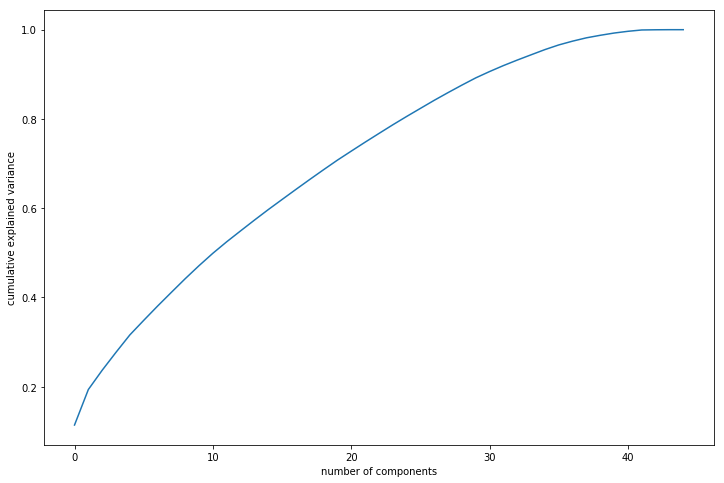

In [136]:
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

#### About 80% variance is captured by 25 components. 90% variance is captured by approximately 30 components. Let's do a gridsearch cross validation find out the optimal number of components.

### Build a logistic regression model with number of PCA components as hyperparameter

In [137]:
help(GridSearchCV)

Help on class GridSearchCV in module sklearn.model_selection._search:

class GridSearchCV(BaseSearchCV)
 |  Exhaustive search over specified parameter values for an estimator.
 |  
 |  Important members are fit, predict.
 |  
 |  GridSearchCV implements a "fit" and a "score" method.
 |  It also implements "predict", "predict_proba", "decision_function",
 |  "transform" and "inverse_transform" if they are implemented in the
 |  estimator used.
 |  
 |  The parameters of the estimator used to apply these methods are optimized
 |  by cross-validated grid-search over a parameter grid.
 |  
 |  Read more in the :ref:`User Guide <grid_search>`.
 |  
 |  Parameters
 |  ----------
 |  estimator : estimator object.
 |      This is assumed to implement the scikit-learn estimator interface.
 |      Either estimator needs to provide a ``score`` function,
 |      or ``scoring`` must be passed.
 |  
 |  param_grid : dict or list of dictionaries
 |      Dictionary with parameters names (string) as ke

In [138]:
model = make_pipeline(PCA(), LogisticRegression(class_weight = 'balanced'))
params = {'pca__n_components':[22, 25, 27, 32, 35, 37, 40],
          'logisticregression__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
n_folds = StratifiedKFold(n_splits = 5, random_state = 100)
gridmodel = GridSearchCV(estimator = model, 
                         param_grid = params,
                         scoring = 'f1',
                         cv = n_folds,
                         n_jobs = -1,
                         return_train_score = True)
result = gridmodel.fit(X_scaled, y_train)

In [139]:
cv_results = pd.DataFrame(result.cv_results_)

In [140]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,param_pca__n_components,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.306284,0.050905,0.006989,0.001670,0.001,22,"{'logisticregression__C': 0.001, 'pca__n_compo...",0.354938,0.346352,0.349112,0.342730,0.357942,0.350215,0.005553,49,0.354815,0.348586,0.346283,0.351256,0.353052,0.350798,0.003056
1,0.303833,0.010518,0.005112,0.001833,0.001,25,"{'logisticregression__C': 0.001, 'pca__n_compo...",0.359690,0.347314,0.352854,0.346667,0.355920,0.352489,0.004989,47,0.355405,0.351976,0.350335,0.352941,0.350242,0.352180,0.001907
2,0.268758,0.018334,0.003569,0.000343,0.001,27,"{'logisticregression__C': 0.001, 'pca__n_compo...",0.356207,0.345229,0.351371,0.347890,0.353383,0.350816,0.003892,48,0.354492,0.350400,0.348651,0.353889,0.351603,0.351807,0.002169
3,0.419710,0.068834,0.003817,0.000425,0.001,32,"{'logisticregression__C': 0.001, 'pca__n_compo...",0.358814,0.353558,0.356021,0.352765,0.356331,0.355498,0.002154,46,0.359954,0.356428,0.354190,0.355456,0.355910,0.356388,0.001931
4,0.346163,0.029433,0.004037,0.000502,0.001,35,"{'logisticregression__C': 0.001, 'pca__n_compo...",0.358653,0.354089,0.356123,0.354354,0.359363,0.356516,0.002163,43,0.360206,0.356428,0.354900,0.355932,0.355246,0.356542,0.001907
5,0.172103,0.032095,0.006119,0.004238,0.001,37,"{'logisticregression__C': 0.001, 'pca__n_compo...",0.357367,0.352324,0.357197,0.353383,0.360211,0.356096,0.002875,44,0.360649,0.356630,0.356003,0.357386,0.357089,0.357551,0.001618
6,0.151741,0.018720,0.004602,0.001248,0.001,40,"{'logisticregression__C': 0.001, 'pca__n_compo...",0.358773,0.353118,0.358819,0.352410,0.356765,0.355977,0.002736,45,0.361857,0.356765,0.357891,0.360023,0.358175,0.358942,0.001794
7,0.467340,0.129884,0.012414,0.005599,0.01,22,"{'logisticregression__C': 0.01, 'pca__n_compon...",0.377622,0.368550,0.384171,0.369692,0.375940,0.375195,0.005683,42,0.383463,0.375654,0.373727,0.378333,0.381154,0.378466,0.003538
8,0.569155,0.111462,0.005893,0.002427,0.01,25,"{'logisticregression__C': 0.01, 'pca__n_compon...",0.381944,0.377483,0.383585,0.382872,0.374475,0.380072,0.003513,38,0.387303,0.382477,0.375287,0.383221,0.381814,0.382020,0.003871
9,0.574194,0.086479,0.004451,0.001778,0.01,27,"{'logisticregression__C': 0.01, 'pca__n_compon...",0.384615,0.373573,0.379768,0.381590,0.376787,0.379267,0.003817,41,0.387633,0.382211,0.377564,0.382737,0.383516,0.382732,0.003213


In [141]:
result.best_score_

0.38941884840237945

In [142]:
result.best_params_

{'logisticregression__C': 1000, 'pca__n_components': 40}

In [143]:
lr_model = make_pipeline(PCA(n_components = 40), LogisticRegression(class_weight = 'balanced', C = 1000))
lr_model.fit(X_scaled, y_train)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=40, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logisticregression', LogisticRegression(C=1000, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))])

In [144]:
y_pred_prob = lr_model.predict_proba(X_scaled)

In [145]:
y_pred_prob[:,1]

array([0.03311857, 0.35244994, 0.09368502, ..., 0.24070983, 0.21902736,
       0.23694624])

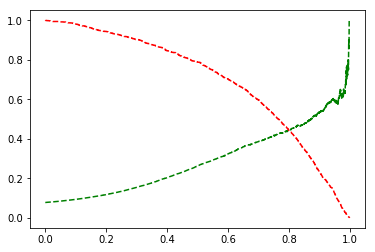

In [146]:
p, r, threshold = precision_recall_curve(y_train, y_pred_prob[:,1])
plt.plot(threshold, p[:-1], "g--")
plt.plot(threshold, r[:-1], "r--")

### Validate the model on test data

In [147]:
y_test_pred_prob = lr_model.predict_proba(scale.transform(x_test))

In [148]:
y_test_pred_prob.shape

(7855, 2)

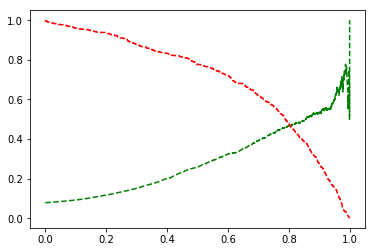

In [149]:
p, r, threshold = precision_recall_curve(y_test, y_test_pred_prob[:,1])
plt.plot(threshold, p[:-1], "g--")
plt.plot(threshold, r[:-1], "r--")

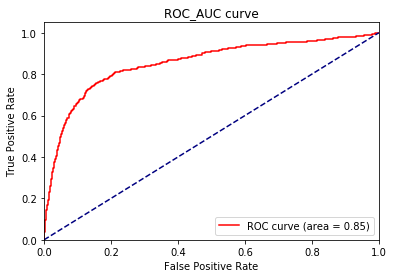

In [150]:
fpr, tpr, threshold = roc_curve(y_test, y_test_pred_prob[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='red',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC curve')
plt.legend(loc="lower right")
plt.show()

#### Observing the precision-recall curve, it appears that the ideal threshold for this data is around 0.2 to 0.4. Let's try that.

In [151]:
thres_df = pd.DataFrame({'y_test':y_test, 'y_predicted_prob':y_test_pred_prob[:,1]})
label_cols = ['y_label_20', 'y_label_30', 'y_label_40']
for enum, i in enumerate([0.2, 0.3, 0.4]):
    thres_df[label_cols[enum]] = thres_df['y_predicted_prob'].map(lambda x : 1 if x > i else 0)

In [152]:
thres_df.head()

,y_test,y_predicted_prob,y_label_20,y_label_30,y_label_40
50459,0,0.406369,1,1,1
15992,1,0.781474,1,1,1
72873,1,0.890276,1,1,1
59976,0,0.744631,1,1,1
80821,0,0.570486,1,1,1


In [153]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_20)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[2868 4370]
 [  38  579]]
False Positive Rate = 0.6


In [154]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_30)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[4184 3054]
 [  75  542]]
False Positive Rate = 0.42


In [155]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_40)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[5191 2047]
 [ 103  514]]
False Positive Rate = 0.28


#### As we increase the threshold from 0.2 to 0.4, true positive rate/sensitivity/recall goes down however, false positive rate goes down as well. 0.4 threshold will strike a balance. Let's look at the classification report before fixing the threshold.

In [156]:
print(classification_report(thres_df.y_test, thres_df.y_label_20))

             precision    recall  f1-score   support

          0       0.99      0.40      0.57      7238
          1       0.12      0.94      0.21       617

avg / total       0.92      0.44      0.54      7855



In [157]:
print(classification_report(thres_df.y_test, thres_df.y_label_30))

             precision    recall  f1-score   support

          0       0.98      0.58      0.73      7238
          1       0.15      0.88      0.26       617

avg / total       0.92      0.60      0.69      7855



In [158]:
print(classification_report(thres_df.y_test, thres_df.y_label_40))

             precision    recall  f1-score   support

          0       0.98      0.72      0.83      7238
          1       0.20      0.83      0.32       617

avg / total       0.92      0.73      0.79      7855



## Model summary and conclusion:
### Threshold 0.4 classifies 83% of churn correctly while balancing with false positive rate
### Prediction algorithm: Logistsic Regression with PCA (pipeline model)
### Model parameters: 40 PCA components, class_weights = 'balanced', C = 1000
### Probability decision threshold: 0.4
### Recall = 83%
### Precision = 20%
### False positive rate = 28%

## Tree based model - RandomForest (Bagging)

#### Let's use the complete data which includes the outliers as well since tree based models are not sensitive to outliers

In [159]:
highvalue_customers.shape

(30001, 47)

In [160]:
X = highvalue_customers.drop(['mobile_number', 'churn'], axis = 1)
y = highvalue_customers['churn']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 100, stratify=y)

In [161]:
from sklearn.ensemble import RandomForestClassifier

In [162]:
rf = RandomForestClassifier(class_weight = 'balanced')
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)
print("Recall:",recall_score(y_test, y_pred))
print("Precision:",precision_score(y_test, y_pred))
print("F1 score",f1_score(y_test, y_pred))

Recall: 0.35382513661202186
Precision: 0.6797900262467191
F1 score 0.4654088050314466


In [163]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, fl

In [164]:
# Build GridSearchCV to find optimal hyperparameters
model = RandomForestClassifier(class_weight = "balanced", n_jobs = -1)
params = {'n_estimators':[50, 150, 250],
          'max_features':[0.3, 0.5, 0.7],
          'max_depth':[4, 6, 9]
          }
n_folds = StratifiedKFold(n_splits = 5, random_state = 100)
gridmodel = GridSearchCV(estimator = model,
                         param_grid = params,
                         cv = n_folds,
                         scoring = 'f1',
                         n_jobs = -1)

In [165]:
gridmodel.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=100, shuffle=False),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50, 150, 250], 'max_features': [0.3, 0.5, 0.7], 'max_depth': [4, 6, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [166]:
cv_results = pd.DataFrame(gridmodel.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.277007,0.045308,0.109430,0.003125,4,0.3,50,"{'max_depth': 4, 'max_features': 0.3, 'n_estim...",0.466790,0.472469,0.455483,0.452514,0.454785,0.460409,0.007802,27,0.471272,0.474522,0.482394,0.482364,0.474301,0.476970,0.004563
1,7.329804,0.261860,0.111967,0.001226,4,0.3,150,"{'max_depth': 4, 'max_features': 0.3, 'n_estim...",0.478424,0.481013,0.453704,0.459813,0.458221,0.466236,0.011220,20,0.474977,0.478553,0.478301,0.487197,0.483092,0.480424,0.004258
2,11.508353,0.232014,0.153101,0.049778,4,0.3,250,"{'max_depth': 4, 'max_features': 0.3, 'n_estim...",0.476548,0.479279,0.459963,0.460094,0.458929,0.466963,0.008992,19,0.472555,0.477703,0.480148,0.484695,0.478022,0.478624,0.003930
3,3.559940,0.097834,0.114003,0.000946,4,0.5,50,"{'max_depth': 4, 'max_features': 0.5, 'n_estim...",0.467167,0.475158,0.453953,0.459792,0.452697,0.461754,0.008434,25,0.470588,0.479813,0.475229,0.480791,0.473384,0.475961,0.003853
4,10.869914,0.100522,0.112347,0.001541,4,0.5,150,"{'max_depth': 4, 'max_features': 0.5, 'n_estim...",0.472248,0.477064,0.462121,0.453258,0.462795,0.465498,0.008341,21,0.472801,0.487479,0.483063,0.487293,0.479239,0.481975,0.005503
5,18.351140,0.176358,0.154381,0.050007,4,0.5,250,"{'max_depth': 4, 'max_features': 0.5, 'n_estim...",0.473684,0.473492,0.453608,0.454460,0.462094,0.463468,0.008776,22,0.475387,0.480792,0.477304,0.485581,0.480074,0.479828,0.003469
6,4.951023,0.241762,0.112883,0.002070,4,0.7,50,"{'max_depth': 4, 'max_features': 0.7, 'n_estim...",0.469043,0.464446,0.462264,0.451734,0.460000,0.461498,0.005724,26,0.469047,0.474164,0.474804,0.484245,0.477230,0.475898,0.004952
7,15.135443,0.124152,0.111593,0.003027,4,0.7,150,"{'max_depth': 4, 'max_features': 0.7, 'n_estim...",0.472486,0.465580,0.451253,0.455146,0.466790,0.462251,0.007847,24,0.473481,0.475923,0.475143,0.483803,0.476657,0.477002,0.003561
8,25.227694,0.185780,0.132978,0.041285,4,0.7,250,"{'max_depth': 4, 'max_features': 0.7, 'n_estim...",0.470919,0.467391,0.460243,0.450518,0.465930,0.463001,0.007127,23,0.470856,0.476840,0.478311,0.483031,0.479925,0.477793,0.004032
9,3.212272,0.080156,0.110422,0.003166,6,0.3,50,"{'max_depth': 6, 'max_features': 0.3, 'n_estim...",0.531411,0.534813,0.509595,0.493724,0.510469,0.516003,0.015227,11,0.548101,0.566136,0.552492,0.555948,0.554826,0.555500,0.005960


In [167]:
gridmodel.best_params_

{'max_depth': 9, 'max_features': 0.5, 'n_estimators': 50}

In [168]:
gridmodel.best_score_

0.5659131345474392

#### Build a random forest model with the best parameters

In [169]:
rf_best = RandomForestClassifier(class_weight = "balanced", max_depth = 9, max_features = 0.3, n_estimators = 250, n_jobs = -1)
rf_best.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=9, max_features=0.3,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=250, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [170]:
y_pred = rf_best.predict(x_test)
print("Recall =",recall_score(y_test, y_pred))
print("Precision =",precision_score(y_test, y_pred))
print("F1 score =",f1_score(y_test, y_pred))

Recall = 0.7021857923497268
Precision = 0.46223021582733814
F1 score = 0.5574837310195228


#### After tuning the hyperparameters, model accuracy has significantly improved. As this is a class imbalance problem, decision threshold needs to be adjusted accordingly.

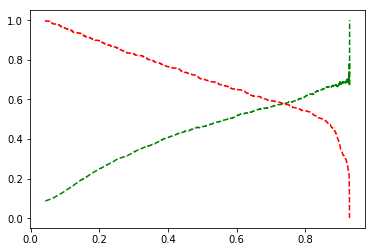

In [171]:
y_test_prob = rf_best.predict_proba(x_test)
p, r, threshold = precision_recall_curve(y_test, y_test_prob[:,1])
plt.plot(threshold, p[:-1], "g--")
plt.plot(threshold, r[:-1], "r--")

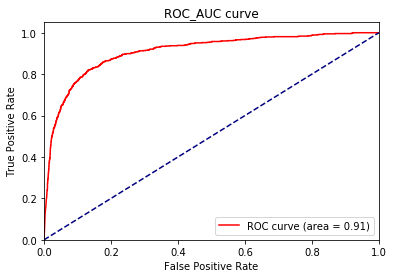

In [172]:
fpr, tpr, threshold = roc_curve(y_test, y_test_prob[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='red',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC curve')
plt.legend(loc="lower right")
plt.show()

#### Observing the precision-recall curve, it appears that the ideal threshold for this data is around 0.2 to 0.4. Let's try that.

In [173]:
thres_df = pd.DataFrame({'y_test':y_test, 'y_predicted_prob':y_test_prob[:,1]})
label_cols = ['y_label_20', 'y_label_30', 'y_label_40']
for enum, i in enumerate([0.2, 0.3, 0.4]):
    thres_df[label_cols[enum]] = thres_df['y_predicted_prob'].map(lambda x : 1 if (x > i) else 0)
thres_df.head()

,y_test,y_predicted_prob,y_label_20,y_label_30,y_label_40
45591,0,0.023866,0,0,0
88300,0,0.161935,0,0,0
51434,0,0.057546,0,0,0
81837,0,0.236747,1,0,0
82750,0,0.062966,0,0,0


In [174]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_20)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[6289 1980]
 [  76  656]]
False Positive Rate = 0.24


In [175]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_30)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[7058 1211]
 [ 124  608]]
False Positive Rate = 0.15


In [176]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_40)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[7452  817]
 [ 171  561]]
False Positive Rate = 0.1


#### As we increase the threshold from 0.2 to 0.4, true positive rate/sensitivity/recall goes down however, false positive rate goes down as well. 0.2 threshold will strike a balance. Let's look at the classification report before fixing the threshold.

In [177]:
print(classification_report(thres_df.y_test, thres_df.y_label_20))

             precision    recall  f1-score   support

          0       0.99      0.76      0.86      8269
          1       0.25      0.90      0.39       732

avg / total       0.93      0.77      0.82      9001



In [178]:
print(classification_report(thres_df.y_test, thres_df.y_label_30))

             precision    recall  f1-score   support

          0       0.98      0.85      0.91      8269
          1       0.33      0.83      0.48       732

avg / total       0.93      0.85      0.88      9001



In [179]:
print(classification_report(thres_df.y_test, thres_df.y_label_40))

             precision    recall  f1-score   support

          0       0.98      0.90      0.94      8269
          1       0.41      0.77      0.53       732

avg / total       0.93      0.89      0.90      9001



## Model Summary:
### Threshold 0.2 classifies 90% of churn correctly
### Algorithm: RandomForestClassifer()
### Model parameters: class_weight = "balanced", max_depth = 9, max_features = 0.3, n_estimators = 250
### Probability decision threshold: 0.2
### Recall = 90%
### Precision = 25%
### False positive rate = 24%

#### Let's find out the  top 5 most influential features

In [180]:
feature_imp_r = pd.DataFrame({'Columns':x_train.columns, 'Importance':rf_best.feature_importances_})
feature_imp_r.sort_values(by = 'Importance', ascending = False, inplace = True)      
feature_imp_r.head()

,Columns,Importance
29,total_rech_amt_diff,0.171960
17,loc_ic_t2m_mou_diff,0.110852
30,total_rech_num_diff,0.075566
32,max_rech_amt_diff,0.069181
33,last_day_rch_amt_diff,0.057393


## Top 5 most influential features/KPIs
1. ### Total recharge amount difference (total_rech_amt_diff)
2. ### Local incoming minutes(operator T to other operator mobile) difference (loc_ic_t2m_mou_diff)
3. ### Maximum recharge amount difference (max_rech_amt_diff)
4. ### Local incoming (operator T to operator T) minutes difference (loc_ic_t2t_mou_diff)
5. ### Total number of recharge difference (total_rech_num_diff)

### Let's try one more tree based model that employs boosting technique to see if prediction gets better

## Tree Based model - XGBoost (Boosting)

In [181]:
from xgboost import XGBClassifier

In [182]:
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of boosted trees to fit.
 |  silent : boolean
 |      Whether to print messages while running boosting.
 |  objective : string or callable
 |      Specify the learning task and the corresponding learning objective or
 |      a custom objective function to be used (see note below).
 |  booster: string
 |      Specify which booster to use: gbtree, gblinear or dart.
 |  nthread : int
 |      Number of parallel threads used to run xgboost.  (Deprecated, please use ``n_jobs``)
 |  n_jobs : int
 |      Number of parallel threads used to run xgboost.  (replaces ``nthread``)
 |  gamma : float
 |      Min

In [183]:
xgb = XGBClassifier(booster = 'gbtree', scale_pos_weight = 11, n_jobs = -1)

#### Choosen 'scale_pos_weight' by dividing the number of negative class examples (0) by number of positive class example as advised in the below forum. This parameter forces a higher penalty on the model when it misclassifies a rare class as opposed to the majority class.

https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets

In [184]:
xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=11,
       seed=None, silent=True, subsample=1)

In [185]:
y_test_pred = xgb.predict(x_test)
recall_score(y_test, y_test_pred)

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.8087431693989071

In [186]:
precision_score(y_test, y_test_pred)

0.3620795107033639

In [187]:
# Build GridSearchCV to choose optimal hyperparameters, especially 'scale_pos_weight'
model = XGBClassifier(booster = 'gbtree', n_jobs = -1)
params = {'estimator__n_estimators':[100, 200, 300],
             'estimator__scale_pos_weight':[7, 9, 11, 12],
             'estimator__max_depth':[4, 7],
             'estimator__colsample_bytree':[0.6, 0.8]
             }
n_folds = StratifiedKFold(n_splits = 4, random_state=100)
xgbgrid = GridSearchCV(estimator = model,
                       param_grid = params,
                       scoring = 'f1',
                       cv = n_folds,
                       n_jobs = -1,
                       verbose = 0)

In [188]:
xgbgrid.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__base_score', 'estimator__booster', 'estimator__colsample_bylevel', 'estimator__colsample_bytree', 'estimator__gamma', 'estimator__learning_rate', 'estimator__max_delta_step', 'estimator__max_depth', 'estimator__min_child_weight', 'estimator__missing', 'estimator__n_estimators', 'estimator__n_jobs', 'estimator__nthread', 'estimator__objective', 'estimator__random_state', 'estimator__reg_alpha', 'estimator__reg_lambda', 'estimator__scale_pos_weight', 'estimator__seed', 'estimator__silent', 'estimator__subsample', 'estimator', 'fit_params', 'iid', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [189]:
xgbgrid.fit(x_train, y_train)

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous

GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=100, shuffle=False),
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'estimator__n_estimators': [100, 200, 300], 'estimator__scale_pos_weight': [7, 9, 11, 12], 'estimator__max_depth': [4, 7], 'estimator__colsample_bytree': [0.6, 0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [190]:
cv_results = pd.DataFrame(xgbgrid.cv_results_)

In [191]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__colsample_bytree,param_estimator__max_depth,param_estimator__n_estimators,param_estimator__scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
0,8.813371,0.068320,0.046003,0.003450,0.6,4,100,7,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
1,8.887164,0.046597,0.046237,0.015622,0.6,4,100,9,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
2,8.921278,0.072898,0.044688,0.010248,0.6,4,100,11,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
3,8.558700,0.081853,0.050946,0.007077,0.6,4,100,12,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
4,8.508863,0.030052,0.061753,0.027707,0.6,4,200,7,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
5,7.933307,0.092318,0.051196,0.018026,0.6,4,200,9,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
6,7.395802,0.028420,0.045791,0.006901,0.6,4,200,11,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
7,7.384868,0.056115,0.043237,0.008870,0.6,4,200,12,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
8,7.518443,0.038246,0.041648,0.005377,0.6,4,300,7,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197
9,7.594746,0.051754,0.039484,0.007104,0.6,4,300,9,"{'estimator__colsample_bytree': 0.6, 'estimato...",0.514604,0.514451,0.507937,0.546463,0.520862,0.015022,1,0.578775,0.57468,0.576159,0.572761,0.575594,0.002197


In [192]:
xgbgrid.best_params_

{'estimator__colsample_bytree': 0.6,
 'estimator__max_depth': 4,
 'estimator__n_estimators': 100,
 'estimator__scale_pos_weight': 7}

In [193]:
xgbgrid.best_score_

0.5208620420283978

In [194]:
xgtest = XGBClassifier(booster = 'gbtree', colsample_bytree = 0.6, max_depth = 4, n_estimators = 100, scale_pos_weight = 7, n_jobs = -1)
xgtest.fit(x_train, y_train)
y_pred_test = xgtest.predict(x_test)
print("/nRecall =",recall_score(y_test, y_pred_test))
print("/nPrecision =",precision_score(y_test, y_pred_test))

/nRecall = 0.7486338797814208
/nPrecision = 0.4370015948963317


/Users/ram/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [195]:
feature_imp = pd.DataFrame({'Columns':x_train.columns, 'Importance':xgtest.feature_importances_})
feature_imp.sort_values(by = 'Importance', ascending = False, inplace = True)      
feature_imp.head()

,Columns,Importance
33,last_day_rch_amt_diff,0.058866
7,day_of_last_rech_diff,0.058866
9,loc_og_t2t_mou_diff,0.044331
18,loc_ic_t2f_mou_diff,0.043605
13,std_og_t2t_mou_diff,0.043605


#### Let's adjust the decision threshold to find optimal recall and precision.

In [196]:
y_test_prob = xgtest.predict_proba(x_test)
y_test_prob

array([[0.99481934, 0.00518064],
       [0.9404297 , 0.05957028],
       [0.93856424, 0.06143576],
       ...,
       [0.85540825, 0.14459175],
       [0.6578057 , 0.3421943 ],
       [0.9844431 , 0.01555685]], dtype=float32)

### Plot a precision-recall curve to get an intuition about the optimal decision threshold

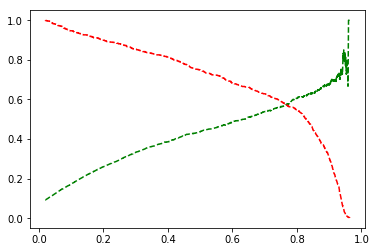

In [197]:
p, r, threshold = precision_recall_curve(y_test, y_test_prob[:,1])
plt.plot(threshold, p[:-1], "g--")
plt.plot(threshold, r[:-1], "r--")

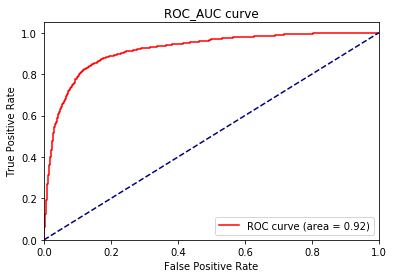

In [198]:
fpr, tpr, threshold = roc_curve(y_test, y_test_prob[:,1], pos_label=1)
plt.figure()
plt.plot(fpr, tpr, color='red',
         label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC_AUC curve')
plt.legend(loc="lower right")
plt.show()

#### Observing the precision-recall curve, it appears that the ideal threshold for this data is around 0.2 to 0.4. Let's try that.

In [199]:
thres_df = pd.DataFrame({'y_test':y_test, 'y_predicted_prob':y_test_prob[:,1]})
label_cols = ['y_label_20', 'y_label_30', 'y_label_40']
for enum, i in enumerate([0.2, 0.3, 0.4]):
    thres_df[label_cols[enum]] = thres_df['y_predicted_prob'].map(lambda x : 1 if (x > i) else 0)
thres_df.head()

,y_test,y_predicted_prob,y_label_20,y_label_30,y_label_40
45591,0,0.005181,0,0,0
88300,0,0.059570,0,0,0
51434,0,0.061436,0,0,0
81837,0,0.244626,1,0,0
82750,0,0.024821,0,0,0


In [200]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_20)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[6390 1879]
 [  74  658]]
False Positive Rate = 0.23


In [201]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_30)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[7012 1257]
 [ 107  625]]
False Positive Rate = 0.15


In [202]:
confusion = confusion_matrix(thres_df.y_test, thres_df.y_label_40)
print(confusion)
print('False Positive Rate =',round((confusion[0,1]/(confusion[0,1]+confusion[0,0])),2))

[[7320  949]
 [ 136  596]]
False Positive Rate = 0.11


#### As we increase the threshold from 0.2 to 0.4, true positive rate/sensitivity/recall goes down however, false positive rate goes down as well. 0.3 threshold will strike a balance. Let's look at the classification report before fixing the threshold.

In [203]:
print(classification_report(thres_df.y_test, thres_df.y_label_20))

             precision    recall  f1-score   support

          0       0.99      0.77      0.87      8269
          1       0.26      0.90      0.40       732

avg / total       0.93      0.78      0.83      9001



In [204]:
print(classification_report(thres_df.y_test, thres_df.y_label_30))

             precision    recall  f1-score   support

          0       0.98      0.85      0.91      8269
          1       0.33      0.85      0.48       732

avg / total       0.93      0.85      0.88      9001



In [205]:
print(classification_report(thres_df.y_test, thres_df.y_label_40))

             precision    recall  f1-score   support

          0       0.98      0.89      0.93      8269
          1       0.39      0.81      0.52       732

avg / total       0.93      0.88      0.90      9001



## Model Summary:
### Threshold 0.2 classifies 90% of churn correctly
### Algorithm: XGBClassifier
### Model parameters: colsample_bytee: 0.6, max_depth: 4, n_estimators: 100, scale_pos_weight: 7
### Probability decision threshold: 0.2
### Recall = 90%
### Precision = 26%
### False positive rate = 23%

In [206]:
feature_imp = pd.DataFrame({'Columns':x_train.columns, 'Importance':xgtest.feature_importances_})
feature_imp.sort_values(by = 'Importance', ascending = False, inplace = True)      
feature_imp.head()

,Columns,Importance
33,last_day_rch_amt_diff,0.058866
7,day_of_last_rech_diff,0.058866
9,loc_og_t2t_mou_diff,0.044331
18,loc_ic_t2f_mou_diff,0.043605
13,std_og_t2t_mou_diff,0.043605


## Top 5 most influential features/KPIs
1. ### Last day recharge amount difference (last_day_rch_amt_diff)
2. ### day of last recharge difference (day_of_last_rech_diff)
3. ### Local outgoing (operator T to operator T) minutes difference (loc_og_t2t_mou_diff)
4. ### Local incoming (operator T to fixed lines of T) minutes difference (loc_ic_t2f_mou_diff)
5. ### STD outgoing (operator T to operator T) minutes difference (std_og_t2t_mou_diff	)

# 4. Summary & Conclusion

## Summary
### Logistic Regression: 
1. Classifies 83% of churn customers while it misclassifies 28% of non-churn cases as churn.
2. No interpretability due to use of PCA.
3. Sensitive to outliers.

### RandomForest:
1. Classifies 90% of churn customers while misclassifying only 24% non-chrun cases as churn.
2. Good interpretability. Top most influential features have been extracted.
3. Not sensitive to outliers.

### XGBoost:
1. Classifies 90% of churn customers while misclassifying only 23% non-chrun cases as churn.
2. Good interpretability. Top most influential features have been extracted.
3. Not sensitive to outliers.

## Conclusion:
### Model chosen for prediction: XGBClassifier (booster = 'gbtree', colsample_bytree = 0.6, max_depth = 4, n_estimators = 100, scale_pos_weight = 7, threshold = 0.2)
#### Reason: Lower FPR rate than RandomForest so it will misclassify lesser non-churn customers while having the same recall rate(90%) as RandomForest.


### Model chosen for feature importance: RandomForestClassifier (class_weight = "balanced", max_depth = 9, max_features = 0.3, n_estimators = 250, threshold = 0.2)
#### Reason: This Model has chosen better features than XGBoost which are easy to monitor and comprehend.

### Top features business needs to monitor to identify customers at risk of churning:
1. #### Total recharge amount difference (total_rech_amt_diff)
2. #### Local incoming minutes(operator T to other operator mobile) difference (loc_ic_t2m_mou_diff)
3. #### Total number of recharge difference (total_rech_num_diff)
4. #### Local incoming (operator T to operator T) minutes difference (max_rech_amt_diff)
5. #### Last day recharge amount difference (last_day_rech_amt_diff)

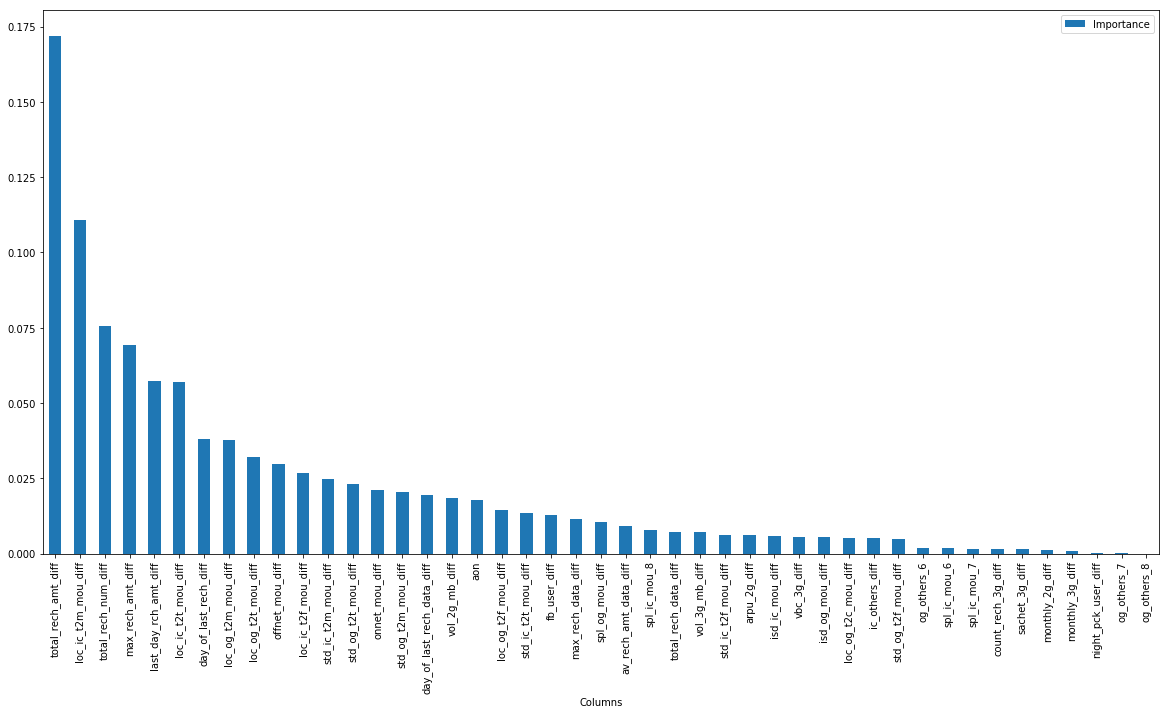

In [210]:
feature_imp_r.set_index('Columns', inplace=True)
feature_imp_r.plot(kind='bar', figsize=(20,10))